In [1]:
import os
import glob
import itertools
import json
import importlib

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl


In [2]:
import py3utils as p3
import rf_utils as rfutils
import plotting as pplot
import roi_utils as rutils
# import gratings_utils as gutils

In [3]:
%matplotlib notebook

# This analysis

In [4]:
def get_x_curves_at_best_y(df, x='morphlevel', y='size', normalize=False):
    best_y = float(df[df['response']==df.groupby([x])['response'].max().max()][y])
    df_ = df[df[y]==best_y]
    #df_[y] = best_y
    if normalize:
        max_d = float(df_['response'].max())
        df_['response'] = df_['response']/max_d
    return df_
        
def get_x_curves_at_given_size(df, x='morphlevel', y='size', val_y=None, normalize=False):
    #val_y = float(df[df['response']==df.groupby([x])['response'].min().min()][y])
    df_ = df[df[y]==val_y]
    #df_[y] = best_y
    if normalize:
        max_d = float(df_['response'].max())
        df_['response'] = df_['response']/max_d
    return df_

def assign_morph_ix(df, at_best_other=True):
    if at_best_other:
        df_ = get_x_curves_at_best_y(df, x='morphlevel', y='size', normalize=False)
    else:
        df_ = df.copy()
    mt = morph_tuning_index(df_['response'].values)
    return pd.Series(mt, name=df_['cell'].unique()[0])

def morph_tuning_index(responses):
    '''
    MT = [n - (sum(Ri)/Rmax)]/(n - 1), from: Zoccolan et al, 2007.
    0: no shape selectivity, 1: maximal shape selectivity
    '''
    n = float(len(responses))
    Rmax = max(responses)
    mt = (n - (sum(responses)/Rmax)) / (n-1)
    return mt

def assign_size_tolerance(df, at_best_other=True):
    if at_best_other:
        df_ = get_x_curves_at_best_y(df, x='size', y='morphlevel', normalize=False)
    else:
        df_ = df.copy()
    mt = size_tolerance(df_['response'].values)
    
    return pd.Series(mt, name=df_['cell'].unique()[0])

def size_tolerance(responses):
    '''
    ST = mean( Rtest / max(Rtest) ), where mean is taken over all sizes.
    0: no size tolerance, 1: perfect size tolerance.
    from: Zoccolan et al, 2007
    '''
    normed_tuning = responses/float(max(responses))
    ST = np.mean(normed_tuning[normed_tuning<1.])
    return ST

def assign_sparseness(df):
    mt = sparseness(df['response'].values)
    return pd.Series(mt, name=df['cell'].unique()[0])

def sparseness(responses):
    '''
    num = 1 - [ (sum(Ri/n)**2) / sum( ((Ri**2)/n) ) ] 
    denom = [1 - (1/n)]
    from:  Zoccolan et al, 2007; Rolls & Tovee, 1995; Vinje and Gallant, 2000; Olshausen and Field, 2004.
    '''
    n = float(len(responses))
    num = 1. - ( (sum(responses/n)**2) / sum( (responses**2)/n ) )
    denom = (1. - (1./n))
    
    return (num/denom)

# def sparseness(responses):
#     '''
#     a = [ (sum(Ri/n)**2) / sum( ((Ri**2)/n) ) ] 
#     Low = high selectivity.
#     from:   Rolls & Tovee, 1995; Vermaerke et al. 2014.
#     '''
#     n = float(len(responses))
#     #num = 1. - ( (sum(responses)/n)**2 / sum( (responses**2)/n ) )
#     #denom = (1. - (1./n))
#     a = (sum(responses/n)**2) / sum( (responses**2) / n )
    
#     return a

In [5]:
def selectivity_and_tolerance(NDATA, SDF, images_only=True, offset=True, exclude=['20190314_JC070_fov1']):
    d_=[]
    for (va, dk), x0 in NDATA.groupby(['visual_area', 'datakey']):
        if dk in exclude:
            continue
        #print(dk)
        sdf = SDF[dk].copy()
        configs = sdf.index.tolist()
        if offset:
            x0['response'] = x0['response'] - x0.groupby(['cell'])['response'].transform('min')
        
        tmpdf = calculate_indices_for_neuraldf(x0[x0.config.isin(configs)], sdf, 
                                               images_only=images_only)
        tmpdf['visual_area'] = va
        tmpdf['datakey'] = dk
        d_.append(tmpdf)

    ixdf = pd.concat(d_, axis=0).reset_index()
    
    return ixdf

def calculate_indices_for_neuraldf(x0, sdf, images_only=False, iternum=None):
#     if x0['response'].min() < 0:
#         print(x0['response'].min())
#         x0['response'] = x0['response']-x0['response'].min()
    #x0['response'] = x0['response'] - x0['response'].min()
#     if offset:
#         x0['response'] = x0['response'] - x0.groupby(['cell'])['response'].transform('min')
    rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
    rdf['size'] = [sdf['size'][c] for c in rdf['config']]
    rdf['morphlevel'] = [sdf['morphlevel'][c] for c in rdf['config']]
    if images_only:
        rdf = rdf[rdf['morphlevel']!=-1]
    # 
    morph_ixs = rdf[rdf['morphlevel']!=-1].groupby(['cell'])\
                    .apply(assign_morph_ix, at_best_other=True)\
                    .rename(columns={0:'morph_ix'})
    size_tols = rdf[rdf['morphlevel']!=-1].groupby(['cell'])\
                    .apply(assign_size_tolerance, at_best_other=True)\
                    .rename(columns={0:'size_tol'})
    sparse_ixs = rdf[rdf['morphlevel']!=-1][['cell', 'response']].groupby(['cell'])\
                    .apply(assign_sparseness).rename(columns={0:'sparseness'})
    #Luminance check
    if -1 in rdf['morphlevel'].values:
        lum_ccs = rdf.groupby(['cell']).apply(get_lum_corr)
        lum_ccs.index = lum_ccs.index.droplevel()
    else:
        lum_ccs = pd.DataFrame({'lum_cc': [None]*len(morph_ixs),
                                'lum_p': [None]*len(morph_ixs)}, index=morph_ixs.index)
    size_sel = rdf[rdf['morphlevel']!=-1].groupby(['cell'])\
                    .apply(assign_lum_ix, at_best_other=True)\
                    .rename(columns={0:'size_ix'})
    lum_sel = rdf[rdf['morphlevel']==-1].groupby(['cell'])\
                    .apply(assign_lum_ix, at_best_other=True)\
                    .rename(columns={0:'lum_ix'})
    # Combine
    ixs_ = pd.concat([morph_ixs, size_tols, size_sel, lum_sel, lum_ccs], axis=1)
    ixs_['cell'] = ixs_.index
    if iternum is not None:
        ixs_['iteration'] = iternum
    return ixs_


In [6]:
def assign_lum_ix(df, at_best_other=True):
    if at_best_other:
        # Get size tuning curve at the best morph
        df_ = get_x_curves_at_best_y(df, x='size', y='morphlevel', normalize=False)
    else:
        df_ = df.copy()
    mt = morph_tuning_index(df_['response'].values)
    return pd.Series(mt, name=df_['cell'].unique()[0])

In [7]:
def get_lum_corr(rd):
    '''Get size tuning curve (at best morph) and 
    luminance tuning curve (same as size-tuning but for morphlevel=-1).
    Calculate correlation coefficient between size- and luminance-tuning curves.
    '''
    lumr = get_x_curves_at_best_y(rd[rd.morphlevel==-1], 
                              x='size', y='morphlevel', normalize=False)
    sizr = get_x_curves_at_best_y(rd[rd.morphlevel!=-1], 
                              x='size', y='morphlevel', normalize=False)
    r_, p_ = spstats.pearsonr(sizr['response'].values, lumr['response'].values)
    
    #pd.Series(mt, name=df_['cell'].unique()[0])
    return pd.DataFrame({'lum_cc': r_, 'lum_p': p_}, index=[rd['cell'].unique()[0]])
    

In [8]:
va='Li'
dk='20190614_JC091_fov1'
x0 = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
offset=response_type=='dff'
sdf = SDF[dk].copy()
configs = sdf.index.tolist()
if offset:
    x0['response'] = x0['response'] - x0.groupby(['cell'])['response'].transform('min')


NameError: name 'NDATA' is not defined

In [ ]:
rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
rdf['size'] = [sdf['size'][c] for c in rdf['config']]
rdf['morphlevel'] = [sdf['morphlevel'][c] for c in rdf['config']]

In [386]:
304 in rdf['cell'].values

True

In [388]:
rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
rdf['size'] = [sdf['size'][c] for c in rdf['config']]
rdf['morphlevel'] = [sdf['morphlevel'][c] for c in rdf['config']]


In [389]:
# 
morph_ixs = rdf[rdf['morphlevel']!=-1].groupby(['cell'])\
                .apply(assign_morph_ix, at_best_other=True)\
                .rename(columns={0:'morph_ix'})
size_tols = rdf[rdf['morphlevel']!=-1].groupby(['cell'])\
                .apply(assign_size_tolerance, at_best_other=True)\
                .rename(columns={0:'size_tol'})
sparse_ixs = rdf[rdf['morphlevel']!=-1][['cell', 'response']].groupby(['cell'])\
                .apply(assign_sparseness).rename(columns={0:'sparseness'})
#Luminance check
if -1 in rdf['morphlevel'].values:
    lum_ccs = rdf.groupby(['cell']).apply(get_lum_corr)
    lum_ccs.index = lum_ccs.index.droplevel()
else:
    lum_ccs = pd.DataFrame({'lum_cc': [None]*len(morph_ixs),
                            'lum_p': [None]*len(morph_ixs)}, index=morph_ixs.index)
size_sel = rdf[rdf['morphlevel']!=-1].groupby(['cell'])\
                .apply(assign_lum_ix, at_best_other=True)\
                .rename(columns={0:'size_ix'})
lum_sel = rdf[rdf['morphlevel']==-1].groupby(['cell'])\
                .apply(assign_lum_ix, at_best_other=True)\
                .rename(columns={0:'lum_ix'})
# Combine
ixs_ = pd.concat([morph_ixs, size_tols, size_sel, lum_sel, lum_ccs], axis=1)
ixs_['cell'] = ixs_.index

<IPython.core.display.Javascript object>


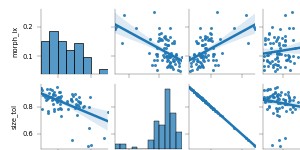

In [391]:
sns.pairplot(ixs_, height=1., plot_kws={'scatter_kws':{'s':3}}, kind='reg')

In [34]:
rd = rdf[(rdf.morphlevel!=-1) & (rdf['cell']==304)].copy()
#[morph_tuning_index(g['response']) for si, g in rd.groupby(['morphlevel'])]
rd.groupby(['morphlevel']).apply(lambda x: morph_tuning_index(x['response']))


morphlevel
0      0.265432
14     0.352726
27     0.195148
40     0.318527
53     0.217134
66     0.364671
79     0.320118
92     0.197086
106    0.213518
dtype: float64

In [35]:
assign_morph_ix(rd, at_best_other=True)

0    0.195279
Name: 304, dtype: float64

In [36]:
df_ = get_x_curves_at_best_y(rd, x='morphlevel', y='size', normalize=False)
df_

,cell,config,response,size,morphlevel
2959,304,config010,0.481256,50.0,0
2964,304,config015,0.539505,50.0,14
2969,304,config020,0.418640,50.0,27
2974,304,config025,0.427807,50.0,40
2979,304,config030,0.413966,50.0,53
2984,304,config035,0.490181,50.0,66
2989,304,config040,0.451500,50.0,79
2994,304,config045,0.397691,50.0,92
2999,304,config050,0.392163,50.0,106


In [40]:
assign_size_tolerance(rd, at_best_other=True)

0    0.647274
Name: 304, dtype: float64

In [38]:
df_ = get_x_curves_at_best_y(rd, x='size', y='morphlevel', normalize=False)
df_

,cell,config,response,size,morphlevel
2960,304,config011,0.259944,10.0,14
2961,304,config012,0.287103,20.0,14
2962,304,config013,0.442517,30.0,14
2963,304,config014,0.407265,40.0,14
2964,304,config015,0.539505,50.0,14


In [41]:
#     n = float(len(responses))
#     Rmax = max(responses)
#     mt = (n - (sum(responses)/Rmax)) / (n-1)

rd = rdf[(rdf.morphlevel==-1) & (rdf['cell']==304)].copy()
morph_tuning_index(rd['response'])

0.5750841332663119

In [46]:
rd = rdf[(rdf.morphlevel!=-1) & (rdf['cell']==304)].copy()
morph_tuning_index(rd['response'])

0.3547494556340286

In [49]:
lumr = rdf[(rdf.morphlevel==-1) & (rdf['cell']==304)].copy()
sizr = rdf[(rdf.morphlevel!=-1) & (rdf['cell']==304)].copy()

lr = assign_lum_ix(lumr)
sr = assign_lum_ix(sizr)
print(lr, sr)

0    0.575084
Name: 304, dtype: float64 0    0.352726
Name: 304, dtype: float64


# Source data

In [9]:
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

traceid = 'traces001'
response_type='dff'
responsive_test='ROC'
responsive_thr = 0.05 if responsive_test=='ROC' else 10.0
trial_epoch = 'plushalf'
overlap_thr=None
overlap_str = 'noRF' if overlap_thr in [None, 'None'] else 'overlap-%.2f' % overlap_thr

fname = 'neuraldata_%s_%s_%s-thr-%.2f_%s_%s' \
        % (traceid, response_type, responsive_test, responsive_thr, trial_epoch, overlap_str)

datafile = os.path.join(aggregate_dir, 'data-stats', 'tmp_data', '%s.pkl' % fname)
with open(datafile, 'rb') as f:
    D = pkl.load(f, encoding='latin1')
D.keys()

dict_keys(['SDF', 'CELLS', 'DATA', 'sdata', 'RFDATA'])

In [10]:
data_id = fname
print(data_id)

neuraldata_traces001_dff_ROC-thr-0.05_plushalf_noRF


In [11]:
importlib.reload(p3)

<module 'py3utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/py3utils.py'>

# Output dir

In [12]:
#### Output dir
dst_dir = os.path.join(aggregate_dir, 'blobs-tuning', 'selectivity_tolerance', responsive_test)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC


In [13]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)


# Selectivity Index + Size Tolerance

In [14]:
NDATA = D['DATA']
SDF = D['SDF']
CELLS=D['CELLS']
response_type='dff'

In [15]:
images_only=False # set False to run LUM checks
remove_offset = response_type=='dff'
ixdf = selectivity_and_tolerance(NDATA, SDF, images_only=False, offset=remove_offset)
ixdf.tail()

,index,morph_ix,size_tol,size_ix,lum_cc,lum_p,cell,visual_area,datakey,lum_ix
2992,364,0.113115,0.829823,0.170177,0.348853,0.565007,364,V1,20191006_JC110_fov1,0.148042
2993,375,0.096838,0.809471,0.190529,-0.013797,0.982434,375,V1,20191006_JC110_fov1,0.123201
2994,380,0.094988,0.905538,0.094462,0.029194,0.962834,380,V1,20191006_JC110_fov1,0.091879
2995,383,0.074614,0.888641,0.111359,0.902374,0.036076,383,V1,20191006_JC110_fov1,0.089712
2996,390,0.115427,0.902053,0.097947,-0.592543,0.292379,390,V1,20191006_JC110_fov1,0.122424


In [16]:
ixdf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

Li    18
Lm    17
V1    16
Name: visual_area, dtype: int64

In [17]:
print(ixdf.min())
print(ixdf.max())


index                            0
morph_ix                  0.015663
size_tol                  0.303209
size_ix                   0.016617
lum_cc                   -0.998576
lum_p                     0.000012
cell                             0
visual_area                     Li
datakey        20190315_JC070_fov1
lum_ix                    0.003578
dtype: object
index                          530
morph_ix                  0.480127
size_tol                  0.983383
size_ix                   0.696791
lum_cc                    0.999525
lum_p                     0.998739
cell                           530
visual_area                     V1
datakey        20191111_JC120_fov1
lum_ix                    0.585139
dtype: object


In [18]:
print(ixdf.min())
print(ixdf.max())


index                            0
morph_ix                  0.015663
size_tol                  0.303209
size_ix                   0.016617
lum_cc                   -0.998576
lum_p                     0.000012
cell                             0
visual_area                     Li
datakey        20190315_JC070_fov1
lum_ix                    0.003578
dtype: object
index                          530
morph_ix                  0.480127
size_tol                  0.983383
size_ix                   0.696791
lum_cc                    0.999525
lum_p                     0.998739
cell                           530
visual_area                     V1
datakey        20191111_JC120_fov1
lum_ix                    0.585139
dtype: object


In [19]:
ixdf_wlum = ixdf.dropna()

In [27]:
drop_repeats_by = 'most_cells'
drop_repeats = True
dset_str = 'drop_repeats_%s' % drop_repeats_by if drop_repeats else 'alldata'
# Drop repeat FOVs
min_ncells = 0
passdf = pd.concat([g for v, g in ixdf_wlum.groupby(['visual_area', 'datakey']) \
                    if (len(g) >= min_ncells) ])
pCELLS = pd.concat([CELLS[(CELLS.visual_area==v) & (CELLS.datakey==dk)] \
               for (v, dk), g in passdf.groupby(['visual_area', 'datakey'])])\
                        .groupby(['visual_area', 'datakey']).count().reset_index()
pCELLS = p3.split_datakey(pCELLS)
# Select by most N cells
unique_dsets = p3.select_best_fovs(pCELLS) #, criterion='max', colname='cell')
unique_dkeys = [(v, k) for (v, k), g in unique_dsets.groupby(['visual_area', 'datakey'])]
excl_dsets = [] #['20190501_JC076_fov1', '20190627_JC091_fov1'] #['20190507_JC083_fov1'] #, '20190501_JC076_fov1'] #, '20190617_JC099_fov1'] #'20191018_JC113_fov1']
passdf_drop = pd.concat([g for (v, k), g in passdf.groupby(['visual_area', 'datakey'])\
                        if (v, k) in unique_dkeys and k not in excl_dsets])
print("All data:")
print(passdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
print("Drop repeats:")
print(passdf_drop[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())


[V1] Animalid does not exist: JC078 
All data:
             datakey
visual_area         
Li                11
Lm                15
V1                16
Drop repeats:
             datakey
visual_area         
Li                 8
Lm                10
V1                 9


In [28]:
final_counts = passdf_drop[['visual_area', 'datakey', 'cell']].drop_duplicates()\
                .groupby(['visual_area', 'datakey']).count().reset_index()
final_counts = p3.split_datakey(final_counts)
final_counts.groupby(['visual_area'])['animalid'].count()

visual_area
Li     8
Lm    10
V1     9
Name: animalid, dtype: int64

In [29]:
final_counts.groupby(['visual_area']).sum()

,cell
visual_area,
Li,402
Lm,684
V1,1028


In [30]:
print("N FOVs:")
print(final_counts.groupby(['visual_area'])['datakey'].count())
m0 = final_counts.groupby(['visual_area'])['cell'].mean().reset_index()
m1 = final_counts.groupby(['visual_area'])['cell'].std().reset_index()
m0['std'] = m1['cell']
m0 = m0.rename(columns={'cell':'mean'})
print(m0)

N FOVs:
visual_area
Li     8
Lm    10
V1     9
Name: datakey, dtype: int64
  visual_area        mean        std
0          Li   50.250000  27.227874
1          Lm   68.400000  50.442927
2          V1  114.222222  61.955181


In [25]:
blobs_dir = os.path.join(aggregate_dir, 'blobs-tuning')
counts_outfile = os.path.join(blobs_dir, 'final_counts.csv')
final_counts.to_csv (r'%s' % counts_outfile, index=False, header=True)
print(counts_outfile)


/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/final_counts.csv


In [32]:
xdf = passdf_drop.copy() if drop_repeats else passdf.copy()
means_by_fov = xdf.dropna().groupby(['visual_area', 'datakey']).mean().reset_index()
ncells_by_fov = xdf.dropna().groupby(['visual_area', 'datakey']).count().reset_index()[['visual_area', 'datakey', 'cell']]\
                    .rename(columns={'cell': 'n_cells'})
mean_indices = pd.merge(means_by_fov, ncells_by_fov, on=['visual_area', 'datakey'])

In [33]:
import statsmodels.api as sm

In [34]:
importlib.reload(p3)

<module 'py3utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/py3utils.py'>

In [35]:
bw_area_colors={'V1': 'gray', 'Lm': 'gray', 'Li': 'gray'}
# visual_areas, area_colors = p3.set_threecolor_palette(c1='#FF86FF', c2='#5E1D8B', c3='#1ACCFF')

fontsize=6
lw=0.25
# p3.set_plot_params(labelsize=6)

MEANS:
  visual_area  size_tol  morph_ix  size_tol_std  morph_ix_std
0          Li  0.847033  0.112036      0.028941      0.019902
1          Lm  0.825760  0.123830      0.022033      0.012422
2          V1  0.816812  0.128124      0.026181      0.019594


<IPython.core.display.Javascript object>


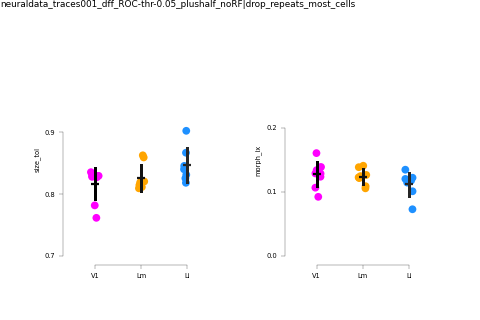

********* [size_tol] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.298320   30.0   9   8
1  V1  Li   False  0.067753   15.0   9   7
2  Lm  Li   False  0.067753   12.0   8   7
****************************
********* [morph_ix] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.235243   28.0   9   8
1  V1  Li   False  0.111008   15.0   9   7
2  Lm  Li   False  0.111008   15.0   8   7
****************************
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC ST_MX_byFOV__dff


In [319]:
plot_cells=False
multi_comp_test='fdr_bh' #'fdr_bh'
bw = True

curr_colors = bw_area_colors if bw else area_colors
plot_params=['size_tol', 'morph_ix']
plot_str = 'byCELL' if plot_cells else 'byFOV'
plotdf = xdf.copy() if plot_cells else mean_indices.copy()
#print(plotdf.groupby(['visual_area']).mean())
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params)

fig, axn = pl.subplots(1, len(plot_params), figsize=(len(plot_params)*3, 4))
ax=axn[0]
metric='size_tol'
for ai, metric in enumerate(['size_tol', 'morph_ix']):
    ax=axn[ai]
    sns.stripplot(x='visual_area', y=metric, data=plotdf, ax=ax, size=7,
                 order=visual_areas, zorder=-1, hue='visual_area', palette=area_colors, #['gray']*3,
                 edgecolor='none', facecolor='white', linewidth=1, jitter=True)
    
    sns.pointplot(x='visual_area', y=metric, data=plotdf, ax=ax,
                 hue='visual_area', color='k', order=visual_areas, join=False, 
                 markers='_', scale=1, zorder=-1, ci='sd')
    ax.legend_.remove()
    if metric=='size_tol':
        y_loc = 0.9 #0.9
        offset = 0.035
    else:
        y_loc = 0.35 if plot_cells else 0.2
        offset = 0.02 if plot_cells else 0.035
        
    if metric=='size_tol' and plot_cells is False:
        ax.set_ylim([0.7, 1.01])
        ax.set_yticks(np.linspace(0.7, 0.9, 3))
    elif metric=='morph_ix' and plot_cells is False:
        ax.set_ylim([0.0, 0.3])
        ax.set_yticks(np.linspace(0., .2, 3))
    else:
        ax.set_ylim([0, 0.25])
    statresults, ax = pplot.plot_mannwhitney(plotdf, metric=metric, ax=ax, fontsize=fontsize, lw=lw,
                                        multi_comp_test=multi_comp_test, y_loc=y_loc, offset=offset)
# ax=axn[2]
# metric='sparseness'
# y_loc=0.1 if plot_cells else 0.04 #0.008 
# offset=0.005 if plot_cells else 0.003
# sns.stripplot(x='visual_area', y=metric, data=plotdf, ax=ax,
#                  hue='visual_area', palette=area_colors, order=visual_areas)
# sns.pointplot(x='visual_area', y=metric, data=plotdf, ax=ax,
#                  hue='visual_area', palette=area_colors, order=visual_areas, join=False, 
#                  markers='_', scale=2)
# statresults, ax = p3.plot_mannwhitney(plotdf, metric=metric, ax=ax, 
#                                     multi_comp_test=multi_comp_test, y_loc=y_loc, offset=offset)


sns.despine(offset=8, trim=True)
pl.subplots_adjust(bottom=0.2, left=0.15, right=0.9, top=0.8, wspace=0.6)
#p3.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(1, 1), loc='upper left') #title='pass(p<%.2f)' % p_thr)
for ax in axn.flat:
    ax.set_xlabel('')    
pplot.label_figure(fig, '%s|%s' % (data_id, dset_str))

# figname = 'ST_MX_%s_%s_%s__%s_%s' % (response_type, plot_str, multi_comp_test, dset_str, overlap_str)
figname = 'ST_MX_byFOV__%s' % (response_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [320]:
importlib.reload(p3)


<module 'py3utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/py3utils.py'>

MEANS:
  visual_area  size_tol  morph_ix  size_tol_std  morph_ix_std
0          Li  0.845802  0.113874      0.076589      0.051219
1          Lm  0.822164  0.126971      0.088359      0.064999
2          V1  0.817626  0.131125      0.096125      0.066033


<IPython.core.display.Javascript object>


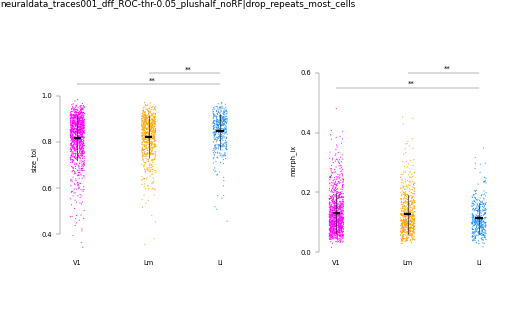

********* [size_tol] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject         p_val     U_val    n1   n2
0  V1  Lm   False  3.116609e-01  344110.0  1028  679
1  V1  Li    True  5.562843e-07  167743.0  1028  395
2  Lm  Li    True  6.492973e-06  112298.0   679  395
****************************
********* [morph_ix] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val     U_val    n1   n2
0  V1  Lm   False  0.091796  335751.0  1028  679
1  V1  Li    True  0.000109  175494.0  1028  395
2  Lm  Li    True  0.006134  121139.0   679  395
****************************
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC ST_MX_byCELL__dff


In [321]:
plot_type = 'POINT'
plot_cells=True
multi_comp_test='fdr_bh' #'fdr_bh'
plot_str = 'byCELL' if plot_cells else 'byFOV' 
plotdf = xdf.copy() 
pplot.print_means(plotdf, groupby=['visual_area'], params=plot_params)

fig, axn = pl.subplots(1,2, figsize=(6.5,4))
ax=axn[0]
for ai, metric in enumerate(['size_tol', 'morph_ix']):
    ax=axn[ai]
    sns.stripplot(x='visual_area', y=metric, data=plotdf, ax=ax,
                 hue=None, order=visual_areas, dodge=0.5,
                 zorder=-1, size=1, jitter=True, palette=area_colors)
    if plot_type=='BOX':
        sns.boxplot(x='visual_area', y=metric, data=plotdf, ax=ax, dodge=0.5,
                     hue='visual_area', color='gray', order=visual_areas, 
               fliersize=0, linewidth=1, notch=True, whis=[2.5, 97.5])
    else:
        sns.pointplot(x='visual_area', y=metric, data=plotdf, ax=ax, 
                    dodge=0.5,ci='sd', hue=None, color='k', 
                    order=visual_areas, scale=1, markers='_', join=False,
                     errwidth=.5)
    #ax.legend_.remove()
    if metric=='size_tol':
        y_loc = 1 #0.9
        offset = 0.05
    else:
        y_loc = 0.5 if plot_cells else 0.2
        offset = 0.05 if plot_cells else 0.02
    if metric=='size_tol':
        ax.set_yticks(np.linspace(0.0, 1.4, 8)) #([0.5, 1.5])
    else:
        ax.set_yticks(np.linspace(0., 0.8, 5)) 
    statresults, ax = pplot.plot_mannwhitney(plotdf, metric=metric, ax=ax, 
                                        multi_comp_test=multi_comp_test, y_loc=y_loc, offset=offset)
    
    sns.despine(bottom=True, offset=2, trim=True, ax=ax)
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')
pl.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.8, wspace=0.5)

pplot.label_figure(fig, '%s|%s' % (data_id, dset_str))

#figname = 'ST_MX_%s_%s_%s__%s_%s' % (plot_type, plot_str, multi_comp_test, dset_str, overlap_str)
#figname = 'ST_MX_distns_bycell' #% (plot_type, plot_str, multi_comp_test, dset_str, overlap_str)
figname = 'ST_MX_byCELL__%s' % response_type #% (plot_type, plot_str, multi_comp_test, dset_str, overlap_str)

pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [322]:
min_ncells = 10
c_=[]
for (va, dk), ixs_ in xdf.groupby(['visual_area', 'datakey']):
    if len(ixs_) < min_ncells:
        continue
    for sel_type in ['morph_ix', 'sparseness']:
        pearsons_r, pearsons_p = spstats.pearsonr(ixs_['size_tol'], ixs_[sel_type])
        c = pd.Series({'selectivity': sel_type, 
                   'pearsons_p': pearsons_p, 'pearsons_r': pearsons_r,
                   'visual_area': va, 'datakey': dk, 'n_cells': len(ixs_)})
        c_.append(c)
corrs = pd.concat(c_, axis=1).T
p_thr=0.05
corrs['pass'] = corrs['pearsons_p'] < p_thr

KeyError: 'sparseness'

<IPython.core.display.Javascript object>


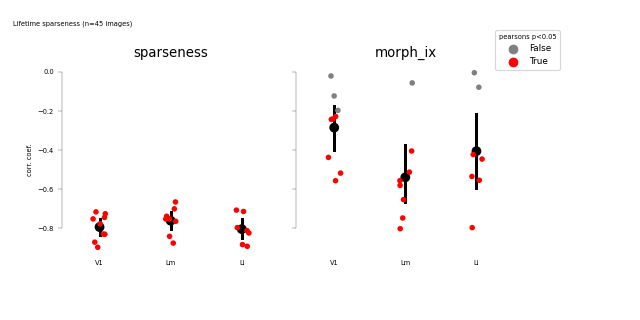

********* [pearsons_r] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.398751   29.0   9   8
1  V1  Li   False  0.500000   31.0   9   7
2  Lm  Li   False  0.398751   18.0   8   7
****************************
********* [pearsons_r] Mann-Whitney U test(mc=fdr_bh) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.057478    6.0   6   7
1  V1  Li   False  0.128178    7.0   6   5
2  Lm  Li   False  0.208396   12.0   7   5
****************************


Text(0.02, 0.92, 'Lifetime sparseness (n=45 images)')

In [323]:
fig, axn = pl.subplots(1,2, figsize=(8, 4), sharex=True, sharey=True)
n_images = 45 
plotd = corrs.copy() #[corrs['pass']].copy()

ax=axn[0]
for ai, (ax, sel_type) in enumerate(zip(axn.flat, ['sparseness', 'morph_ix'])):
    sns.stripplot(x='visual_area', y='pearsons_r', data=plotd[plotd.selectivity==sel_type], ax=ax,
                 hue='pass', palette={True: 'r', False: 'gray'}, dodge=False, order=visual_areas)
    
    sns.pointplot(x='visual_area', y='pearsons_r', data=plotd[plotd.selectivity==sel_type], ax=ax,
                 color='k', dodge=False, join=False, order=visual_areas)
    y_loc=0.1
    offset=0.1
    statresults, ax = pplot.plot_mannwhitney(plotd[(plotd.selectivity==sel_type) & (plotd['pearsons_p']<0.05)],
                                    metric='pearsons_r', ax=ax, 
                                    multi_comp_test=multi_comp_test, y_loc=y_loc, offset=offset)
    ax.set_title(sel_type, fontsize=12)
    if ai==0:
        ax.legend_.remove()
        ax.set_ylabel('corr. coef.')
    else:
        ax.set_ylabel('')
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('')

sns.despine(offset=2, trim=True, bottom=True)
pplot.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(0.9,1.2), loc='upper left', 
                        title='pearsons p<%.2f' % p_thr, fontsize=8)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.8, wspace=0.1)

fig.text(0.02, 0.92, 'Lifetime sparseness (n=%i images)' % n_images)

In [324]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, RidgeCV, LinearRegression

from sklearn import metrics as skmetrics
import random
import copy
import sklearn.utils as skutils

In [325]:
def fit_regression(ixs_, xvar='morph_ix', yvar='size_tol'):
    xx_ = ixs_[xvar].values.reshape(-1, 1)
    yy_ = ixs_[yvar].values.reshape(-1, 1)
    # Fit OLS
    regr = make_pipeline(StandardScaler(), 
                         RidgeCV(alphas=np.logspace(-10, 10, 21)))
    X = ixs_[[xvar]].copy()
    y = ixs_[yvar].copy()
    regr.fit(X, y)
    y_pred = regr.predict(X)
    y_test = copy.copy(y)
    # metrics
    pearsons_r, pearsons_p = spstats.pearsonr(X.values[:, 0], y)
    R2 = skmetrics.r2_score(y_test, y_pred)
    MSE = skmetrics.mean_squared_error(y_test, y_pred)
    MAE = skmetrics.median_absolute_error(y_test, y_pred)
#         B0 = float(regr.intercept_)
#         B1 = float(regr.coef_)
    B0=float(regr.named_steps['ridgecv'].coef_)
    B1=float(regr.named_steps['ridgecv'].intercept_)
    res = {'pearsons_r': float(pearsons_r), 'pearsons_p': float(pearsons_p), 
           'R2': R2, 'MSE': MSE, 'MAE': MAE, 
           'coef': B0, 'intercept': B1, 'selectivity': xvar,
           'x': xvar, 'y': yvar, 'n_cells': len(ixs_['cell'].unique())}
    return res

In [326]:
def shuffle_pearsons(ixs_, xvar='morph_ix', yvar='size_told', n_iters=1000):
    xx = ixs_[xvar].values
    yy = ixs_[yvar].values
    pearsons_r, pearsons_p = spstats.pearsonr(xx, yy)
    n_points = len(xx)
    shuff = np.concatenate((xx, yy))
    s_=[]
    for i in np.arange(0, n_iters):
        np.random.shuffle(xx)
        np.random.shuffle(yy)
        shuff_r, shuff_p = spstats.pearsonr(xx, yy)
        s_.append((shuff_r, shuff_p))
    shuff_results = pd.DataFrame(s_, columns=['r', 'p'])
    p_val = shuff_results[shuff_results['r'].abs()>abs(pearsons_r)].shape[0]/float(n_iters)
    curr_res = {'pearsons_r': pearsons_r, 'pearsons_p': pearsons_p,
                'p_val': p_val, 'n_cells': n_points}
    return curr_res

In [327]:
max_nfovs = xdf[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts().max()
max_nfovs

9

<IPython.core.display.Javascript object>


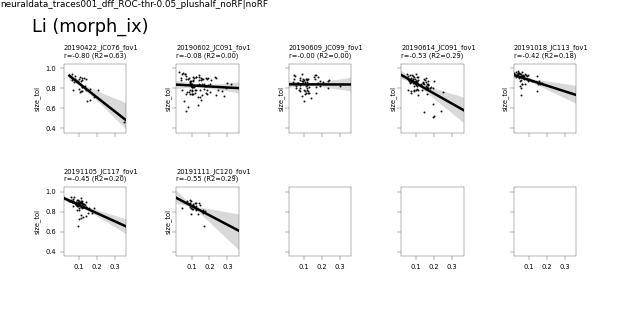

<IPython.core.display.Javascript object>


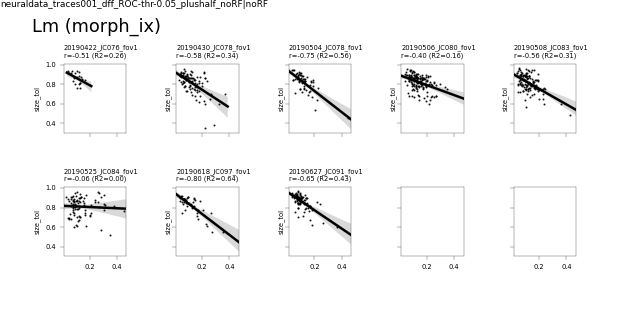

<IPython.core.display.Javascript object>


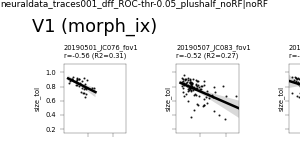

In [328]:
xvar = 'morph_ix'
yvar = 'size_tol'
r_ = []
for visual_area, vg in xdf.groupby(['visual_area']):
    n_fovs = len(vg['datakey'].unique())
    fig, axn = pl.subplots(2, 5, figsize=(8, 4), sharex=True, sharey=True)
    for ax, (datakey, ixs_) in zip(axn.flat, vg.groupby(['datakey'])):
        if len(ixs_) < min_ncells:
            ax.set_title('%s\n(n=%i cells)' % (datakey, len(ixs_)), loc='left', fontsize=6)
            continue
        res = fit_regression(ixs_, xvar=xvar, yvar=yvar)
        res.update({'visual_area': visual_area, 'datakey': datakey})
        r_.append(pd.Series(res))
        # plot
        sns.regplot(x=xvar, y=yvar, data=ixs_, color='k', marker='.', ax=ax, 
                    scatter_kws={'s':3}, truncate=False) #, size=2)\
        lc = 'r' if R2>0.5 else 'k'
        ax.set_xlabel('')
        ax.set_title('%s\nr=%.2f (R2=%.2f)' % (datakey, res['pearsons_r'], res['R2']), 
                     loc='left', fontsize=6)   
    pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.8, hspace=0.8)
    fig.text(0.05, 0.9, '%s (%s)' % (visual_area, sel_type), fontsize=16)
    p3.label_figure(fig, '%s|%s' % (data_id, overlap_str))
    #pl.savefig(os.path.join(dst_dir, 'correlations_%s_dsets_%s.png' % (visual_area, overlap_str)))
regressiondf = pd.concat(r_, axis=1).T #reset_index(drop=True)

In [329]:
fits_regr = [tuple(k) for k in regressiondf[regressiondf['R2']>0.][['visual_area', 'datakey']].values]
passregr = pd.concat([g for (v,k), g in xdf.groupby(['visual_area', 'datakey'])\
                      if (v,k) in fits_regr])


In [232]:
va='Li'
dk = '20190422_JC076_fov1'
ixs_ = passregr[(passregr.visual_area==va) & (passregr.datakey==dk)]


In [233]:
    xx = ixs_[xvar].values
    yy = ixs_[yvar].values
    pearsons_r, pearsons_p = spstats.pearsonr(xx, yy)
    n_points = len(xx)
    shuff = np.concatenate((xx, yy))
    s_=[]
    for i in np.arange(0, n_iters):
        np.random.shuffle(xx)
        np.random.shuffle(yy)
        shuff_r, shuff_p = spstats.pearsonr(xx, yy)
        s_.append((shuff_r, shuff_p))
    shuff_results = pd.DataFrame(s_, columns=['r', 'p'])
    p_val = shuff_results[shuff_results['r'].abs()>abs(pearsons_r)].shape[0]/float(n_iters)
    curr_res = {'pearsons_r': pearsons_r, 'pearsons_p': pearsons_p,
                'p_val': p_val, 'n_cells': n_points}

In [237]:
shuff_results['r']

0     -0.340603
1     -0.203399
2     -0.125328
3      0.308955
4      0.272693
         ...   
995   -0.237632
996   -0.167011
997   -0.289229
998   -0.034747
999   -0.016151
Name: r, Length: 1000, dtype: float64

In [330]:
n_iters=1000
r_ = []
for (visual_area, datakey), ixs_ in passregr.groupby(['visual_area', 'datakey']):
    if len(ixs_) < min_ncells:
        continue
    curr_res = shuffle_pearsons(ixs_, xvar=xvar, yvar=yvar, n_iters=n_iters)
    curr_res.update({'visual_area': visual_area, 'datakey': datakey})
    r_.append(pd.Series(curr_res))
pearsonsdf = pd.concat(r_, axis=1).T
print(pearsonsdf.shape)
print(pearsonsdf[pearsonsdf['p_val']<0.05].shape)
pearsonsdf[['p_val', 'pearsons_r',  'pearsons_p']] = pearsonsdf[['p_val', 'pearsons_r',  'pearsons_p']].astype(float)

(24, 6)
(18, 6)


In [331]:
p_thr=0.05
print(p_thr)
print(pearsonsdf[pearsonsdf['p_val']<p_thr][['visual_area', 'datakey']]\
      .drop_duplicates()['visual_area'].value_counts())

0.05
Lm    7
V1    6
Li    5
Name: visual_area, dtype: int64


In [332]:
pearsonsdf

,pearsons_r,pearsons_p,p_val,n_cells,visual_area,datakey
0,-0.796839,2.313860e-07,0.000,29,Li,20190422_JC076_fov1
1,-0.078234,4.713568e-01,0.473,87,Li,20190602_JC091_fov1
2,-0.003923,9.768953e-01,0.977,57,Li,20190609_JC099_fov1
3,-0.534827,4.555560e-07,0.000,78,Li,20190614_JC091_fov1
4,-0.422750,3.072840e-03,0.006,47,Li,20191018_JC113_fov1
5,-0.445929,1.556335e-04,0.000,67,Li,20191105_JC117_fov1
6,-0.554276,1.481878e-03,0.002,30,Li,20191111_JC120_fov1
7,-0.512595,1.471676e-02,0.011,22,Lm,20190422_JC076_fov1
8,-0.580543,3.708652e-10,0.000,98,Lm,20190430_JC078_fov1
9,-0.747487,1.039314e-11,0.000,59,Lm,20190504_JC078_fov1


MEANS:
  visual_area     p_val  pearsons_r  p_val_std  pearsons_r_std
0          Li  0.001600   -0.550924   0.002608        0.148490
1          Lm  0.001571   -0.608203   0.004158        0.137327
2          V1  0.004000   -0.370644   0.007925        0.151060


<IPython.core.display.Javascript object>


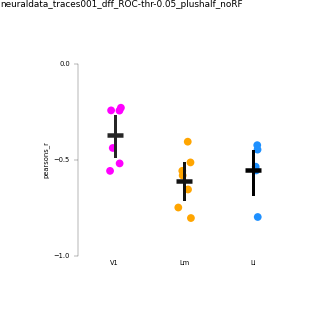

********* [pearsons_r] Mann-Whitney U test(mc=bonferroni) **********
   d1  d2  reject     p_val  U_val  n1  n2
0  V1  Lm   False  0.057478    6.0   6   7
1  V1  Li   False  0.256355    7.0   6   5
2  Lm  Li   False  0.625189   12.0   7   5
****************************
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC tradeoff_corrcoefs_byFOV


In [333]:
multi_comp_test='bonferroni'
p_thr=0.05 #0.001 #01

pcorrdf = pearsonsdf[pearsonsdf['p_val']<p_thr].copy()
#print(pcorrdf.groupby(['visual_area']).mean())
pplot.print_means(pcorrdf, groupby=['visual_area'], params=['p_val', 'pearsons_r'])
fig, ax = pl.subplots(figsize=(4,4))
sns.stripplot(x='visual_area', y='pearsons_r', data=pcorrdf, ax=ax,
             order=visual_areas, zorder=-1, hue='visual_area', palette=area_colors,  size=7,
             edgecolor='gray', facecolor='white', linewidth=0, jitter=True)
sns.pointplot(x='visual_area', y='pearsons_r', data=pcorrdf, ax=ax,
              hue='visual_area', color='k', markers='_', scale=2, join=False,
             order=visual_areas, hue_order=visual_areas, zorder=-1)
y_loc=-0.1
offset=0.05
statresults, ax = pplot.plot_mannwhitney(pcorrdf, metric='pearsons_r', ax=ax, 
                                multi_comp_test=multi_comp_test, 
                                         y_loc=y_loc, offset=offset)
ax.legend_.remove()
ax.set_ylim([-1, 0])
ax.set_yticks(np.linspace(-1, 0, 3))
sns.despine(trim=True, offset=2, bottom=True)
ax.tick_params(which='both', axis='x', size=0)
pl.subplots_adjust(left=0.25, right=0.9, bottom=0.2, top=0.8)
ax.set_xlabel('')
pplot.label_figure(fig, data_id)
#figname = 'corrcoef_pass-boot-%.3f_%s_%s__%s_%s' %(p_thr, response_type, multi_comp_test, dset_str, overlap_str)
figname = 'tradeoff_corrcoefs_byFOV' #%(p_thr, response_type, multi_comp_test, dset_str, overlap_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

# Luminance check

<IPython.core.display.Javascript object>


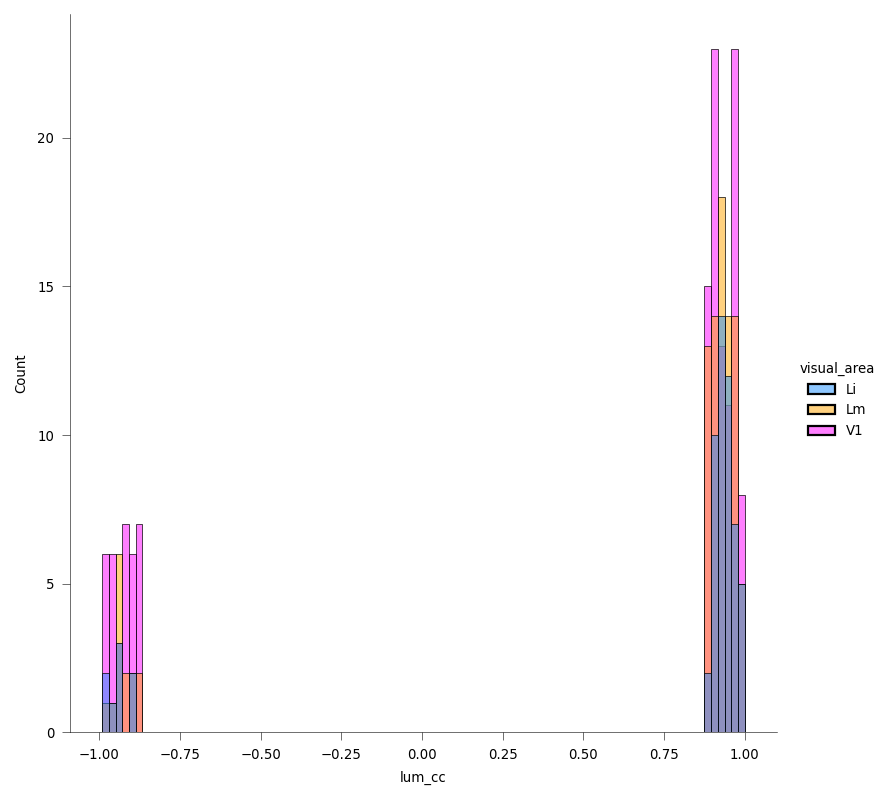

In [36]:
lum = xdf[xdf['lum_p']<0.05]
sns.displot(data=lum, x='lum_cc', hue='visual_area', palette=area_colors)

In [37]:
xdf['sig_lum'] = xdf['lum_p'] < 0.05

<IPython.core.display.Javascript object>


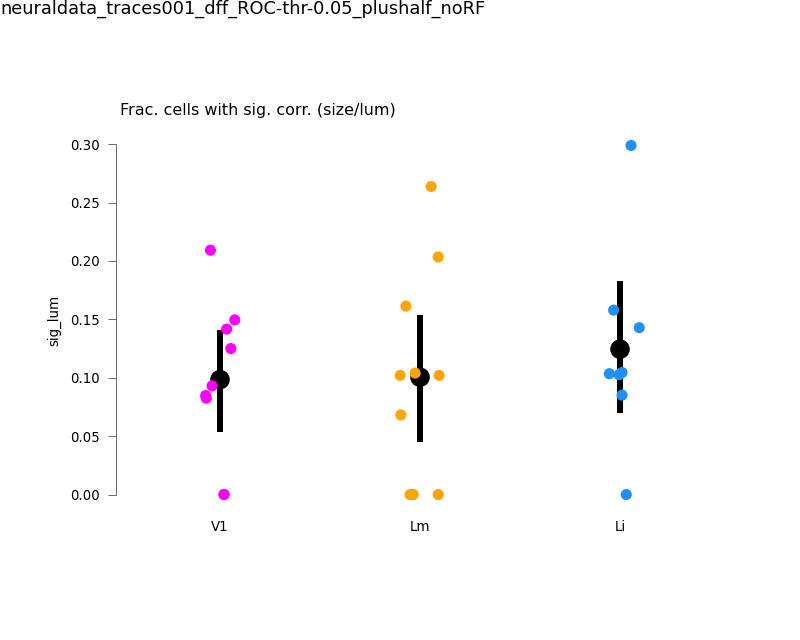

[mean]:
  visual_area   sig_lum  sig_lum_std
0          Li  0.124400     0.084708
1          Lm  0.100468     0.089623
2          V1  0.098403     0.068284
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC fraction_sig_lum


In [60]:
means_by_fov = xdf.groupby(['visual_area', 'datakey']).mean().reset_index()
fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y='sig_lum', data=means_by_fov,
             hue='visual_area', palette=area_colors, ax=ax, order=visual_areas)
sns.pointplot(x='visual_area', y='sig_lum', data=means_by_fov,
             color='k', ax=ax, join=False, order=visual_areas)
pplot.print_means(means_by_fov, groupby=['visual_area'],
                 params=['sig_lum'])
sns.despine(trim=True, offset=2, bottom=True)
ax.tick_params(which='both', axis='x', size=0)
pl.subplots_adjust(left=0.15, right=0.9, bottom=0.2, top=0.8)
ax.set_xlabel('')
ax.legend_.remove()
ax.set_title("Frac. cells with sig. corr. (size/lum)", loc='left')

pplot.label_figure(fig, data_id)
figname = 'fraction_sig_lum' #%(p_thr, response_type, multi_comp_test, dset_str, overlap_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [61]:
lum = xdf[xdf['lum_p']<0.05]
lum.head()

,index,morph_ix,size_tol,size_ix,lum_cc,lum_p,cell,visual_area,datakey,lum_ix,sig_lum
105,76,0.348844,0.456710,0.543290,0.939572,0.017669,76,Li,20190422_JC076_fov1,0.572135,True
115,266,0.115023,0.900470,0.099530,-0.891093,0.042432,266,Li,20190422_JC076_fov1,0.034567,True
124,293,0.145314,0.673939,0.326061,0.941303,0.01692,293,Li,20190422_JC076_fov1,0.158769,True
134,13,0.159484,0.732172,0.267828,0.984529,0.002305,13,Li,20190602_JC091_fov1,0.354197,True
136,16,0.101975,0.775057,0.224943,0.914763,0.029488,16,Li,20190602_JC091_fov1,0.349956,True


In [62]:
lum['abs_cc'] = lum['lum_cc'].abs()

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


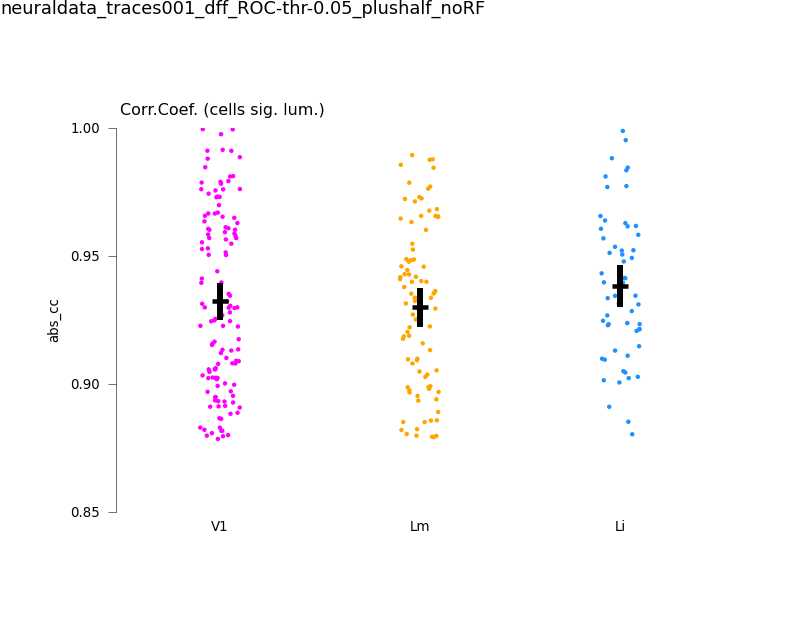

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC corrcoef_siglum


In [73]:
fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y='abs_cc', data=lum[lum.sig_lum],
             hue='visual_area', palette=area_colors, ax=ax, 
             size=2, zorder=-1, order=visual_areas)
sns.pointplot(x='visual_area', y='abs_cc', data=lum[lum.sig_lum],
             color='k', ax=ax, join=False, zorder=10000, order=visual_areas,
              markers='_', scale=1, errwdith=1)
ax.legend_.remove()
ax.set_ylim([0.85, 1])
ax.set_yticks(np.linspace(0.85, 1, 4))

sns.despine(trim=True, offset=2, bottom=True)
ax.tick_params(which='both', axis='x', size=0)
pl.subplots_adjust(left=0.15, right=0.9, bottom=0.2, top=0.8)
ax.set_xlabel('')
ax.set_title("Corr.Coef. (cells sig. lum.)", loc='left')

pplot.label_figure(fig, data_id)
figname = 'corrcoef_siglum' #%(p_thr, response_type, multi_comp_test, dset_str, overlap_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [156]:
curr_dst_dir = os.path.join(dst_dir, 'luminance_examples')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC/luminance_examples


In [110]:
va='V1'
lum[(lum.sig_lum) & (lum.visual_area==va)
   & (lum['size_ix']>0.28)].sort_values(by=['morph_ix', 'lum_ix', 'size_ix'], ascending=False)

,index,morph_ix,size_tol,size_ix,lum_cc,lum_p,cell,visual_area,datakey,lum_ix,sig_lum,abs_cc
2654,254,0.317410,0.610847,0.389153,0.999448,0.000016,254,V1,20190617_JC097_fov1,0.044131,True,0.999448
2780,168,0.197448,0.423397,0.576603,0.905809,0.034207,168,V1,20190622_JC085_fov1,0.226849,True,0.905809
2158,67,0.194223,0.648275,0.351725,0.891133,0.042409,67,V1,20190522_JC084_fov1,0.149662,True,0.891133
2765,87,0.182563,0.653880,0.346120,0.944027,0.015762,87,V1,20190622_JC085_fov1,0.122054,True,0.944027
2803,213,0.155602,0.679767,0.320233,0.913529,0.030125,213,V1,20190622_JC085_fov1,0.184767,True,0.913529
2198,155,0.154799,0.461127,0.538873,0.939665,0.017629,155,V1,20190522_JC084_fov1,0.225968,True,0.939665
2291,115,0.150154,0.632719,0.367281,0.930555,0.021738,115,V1,20190613_JC097_fov1,0.170003,True,0.930555
2305,139,0.145398,0.702331,0.297669,0.891474,0.042212,139,V1,20190613_JC097_fov1,0.149145,True,0.891474
2630,201,0.141416,0.642348,0.357652,0.879616,0.049225,201,V1,20190617_JC097_fov1,0.086176,True,0.879616
2213,203,0.139265,0.586144,0.413856,0.904754,0.034777,203,V1,20190522_JC084_fov1,0.309230,True,0.904754


In [128]:
rid in CELLS[(CELLS.visual_area==va) & (CELLS.datakey==dk)]['cell'].unique()

False

In [133]:
xdf[(xdf.visual_area==va) & (xdf.datakey==dk) & (xdf['cell']==rid)]

,index,morph_ix,size_tol,size_ix,lum_cc,lum_p,cell,visual_area,datakey,lum_ix,sig_lum
124,293,0.145314,0.673939,0.326061,0.941303,0.01692,293,Li,20190422_JC076_fov1,0.158769,True


#### Example traces, luminance

In [203]:
# load traces
rootdir = '/n/coxfs01/2p-data'

# va='Li'
# dk='20190422_JC076_fov1'
# rid=293

# va='V1'
# dk='20190617_JC097_fov1'
# rid=39


va='V1'
dk='20190616_JC097_fov1'
rid=235

session, animalid, fovn = p3.split_datakey_str(dk)
traces, labels = p3.load_corrected_dff_traces(animalid, session, 'FOV%i_zoom2p0x' % fovn, 
                                                return_traces=True, return_labels=True)
stim_on_frame = labels['stim_on_frame'].unique()[0]
nframes_on = labels['nframes_on'].unique()[0]
stim_on_sec = round(stim_on_frame/44.65, 1)
# Set plotting configs
with_lum = True
lum_str = '_wLUM' if with_lum else ''
sdf = SDF[dk].copy()
if with_lum:
    curr_cfgs = sdf.index.tolist()
else:
    curr_cfgs = sdf[sdf['morphlevel']!=-1].index.tolist()
sizes = list(sorted(sdf.loc[curr_cfgs]['size'].unique()))
morphlevels = list(sorted(sdf.loc[curr_cfgs]['morphlevel'].unique()))

M = morphlevels[1:]
M.append(morphlevels[0])
print(M)

... calculating F0 for df/f
[0, 14, 27, 40, 53, 66, 79, 92, 106, -1]


In [204]:
x0 = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
offset=True
sdf = SDF[dk].copy()
configs = sdf.index.tolist()
if offset:
    x0['response'] = x0['response'] - x0.groupby(['cell'])['response'].transform('min')
rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
rdf['size'] = [sdf['size'][c] for c in rdf['config']]
rdf['morphlevel'] = [sdf['morphlevel'][c] for c in rdf['config']]

In [205]:
# Add stim config infor to traces for plotting
rtraces = labels.copy()
rtraces['dff'] = traces[rid].copy()
currt = rtraces[rtraces.config.isin(curr_cfgs)].copy()
currt['size'] = sdf.loc[currt['config']]['size'].values
currt['morphlevel'] = sdf.loc[currt['config']]['morphlevel'].values

In [206]:
rid in rdf['cell'].unique()

True

In [207]:
rd = rdf[rdf['cell']==rid].copy()

lumr = get_x_curves_at_best_y(rd[rd.morphlevel==-1], 
                          x='size', y='morphlevel', normalize=False)
sizr = get_x_curves_at_best_y(rd[rd.morphlevel!=-1], 
                          x='size', y='morphlevel', normalize=False)
r_, p_ = spstats.pearsonr(sizr['response'].values, lumr['response'].values)
print(r_, p_)

best_mp = float(sizr['morphlevel'].unique())

-0.5090370162634177 0.3810677419536273


<IPython.core.display.Javascript object>


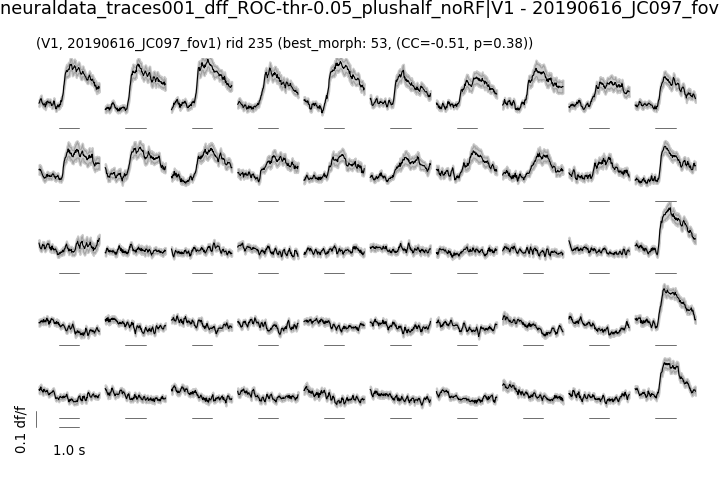

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC/luminance_examples


In [211]:
# plot
ylim_marker=0.1
ylim=0.5
ls='-'
fill_sem=True
mean_only=False
fig, axn = pl.subplots(5, len(morphlevels), figsize=(4.5, 3), sharex=True, sharey=True)
for (sz, mp), g in currt.groupby(['size', 'morphlevel']):
    si = sizes[::-1].index(sz)
    mi = M.index(mp)
    ax=axn[si, mi]
    ax.patch.set(alpha=0)
    t_df = g.groupby(['trial'])['dff'].apply(smooth_traces_trial, win_size=5).unstack().T
    mean_t = np.nanmean(t_df, axis=1)
    std_t = np.nanstd(t_df, axis=1)
    sem_t = spstats.sem(t_df, axis=1, nan_policy='omit')
    if not mean_only:
        if fill_sem:
            ax.fill_between(np.arange(0, len(mean_t)), mean_t-sem_t, mean_t+sem_t, alpha=0.2, color='k')
        else:
            ax.plot(t_df, lw=0.1, color='gray', alpha=1) #'k')
    ax.plot(mean_t, lw=.5, c='k', linestyle=ls) #, label='%s %i' % (hue_, curr_hue))
    ax.plot([stim_on_frame, stim_on_frame+nframes_on], [0.06, 0.06], lw=0.25, color='k')

    # format
    if not (mi==0 and si==len(sizes)-1):
        #sns.despine(trim=True, ax=ax, left=True)
        ax.axis('off')
        #ax.set_yticklabels('')
    else:
        sns.despine(trim=True, ax=ax) #, bottom=True, left=True, ax=ax)
        ax.set_xlabel('%s s' % (stim_on_sec))
        ax.set_yticklabels(['', '%.1f df/f' % ylim_marker], rotation=90)
    ax.set_xticks([stim_on_frame, stim_on_frame+nframes_on])
    ax.tick_params(which='both', axis='both', size=0)
    ax.set_xticklabels([])
    ax.set_yticks([0.0, ylim_marker])
    ax.set_ylim([0.0, ylim])
#sns.despine(trim=True, offset=0.2)
pl.subplots_adjust(left=0.05, right=0.97, wspace=0, hspace=-.1)
fig.text(0.05, 0.9, 
         '(%s, %s) rid %i (best_morph: %i, (CC=%.2f, p=%.2f))' \
         % (va, dk, rid, best_mp, r_, p_))

p3.label_figure(fig, '%s|%s - %s' % (data_id, va, dk))
pl.savefig(os.path.join(curr_dst_dir, 'traces_%s_%s_cell%03d.svg' % (va, dk, rid)))
print(curr_dst_dir)

In [197]:
sizr

,cell,config,response,size,morphlevel
1055,39,config006,0.168077,10.0,0
1056,39,config007,0.235198,20.0,0
1057,39,config008,0.207224,30.0,0
1058,39,config009,0.189450,40.0,0
1059,39,config010,0.188129,50.0,0


<IPython.core.display.Javascript object>


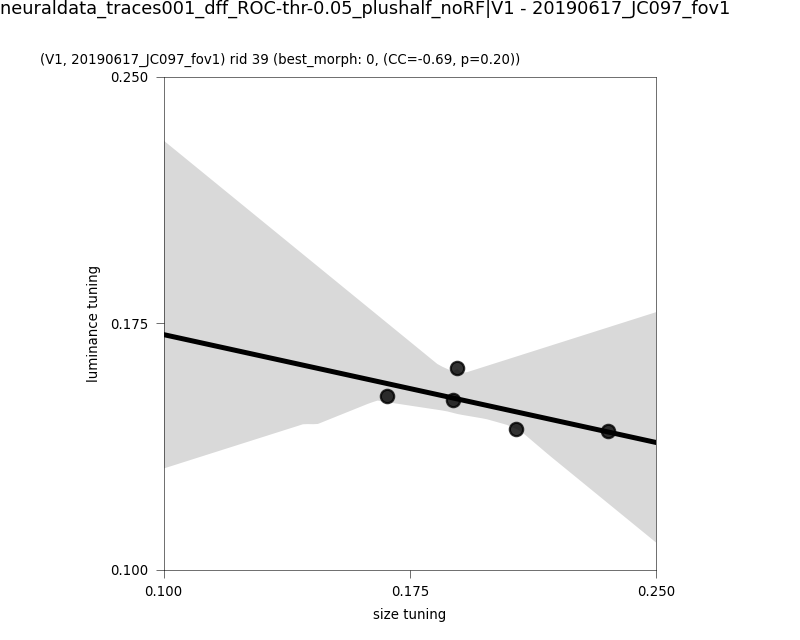

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC/luminance_examples


In [202]:
vmin=min([ax.get_ylim()[0], ax.get_xlim()[0]])
vmax=max([ax.get_ylim()[-1], ax.get_xlim()[-1]])

vmin = 0.1
vmax=0.25
fig, ax = pl.subplots()
ax.set_ylim([vmin, vmax])
ax.set_xlim([vmin, vmax])
ax.set_yticks(np.linspace(vmin, vmax, 3))
ax.set_xticks(np.linspace(vmin, vmax, 3))
ax.set_aspect('equal')
sns.regplot(sizr['response'], lumr['response'], color='k', truncate=False, ax=ax)
ax.set_ylabel('luminance tuning')
ax.set_xlabel('size tuning')

fig.text(0.05, 0.9, 
         '(%s, %s) rid %i (best_morph: %i, (CC=%.2f, p=%.2f))' \
         % (va, dk, rid, best_mp, r_, p_))

p3.label_figure(fig, '%s|%s - %s' % (data_id, va, dk))
pl.savefig(os.path.join(curr_dst_dir, 'regplot_%s_%s_cell%03d.svg' % (va, dk, rid)))
print(curr_dst_dir)

In [375]:
va='Li'
dk = '20190614_JC091_fov1'
rid = 304 #293
xdf[(xdf.datakey==dk) & (xdf['cell']==rid) ]

,index,morph_ix,size_tol,lum_cc,lum_p,cell,visual_area,datakey,sig_lum
475,304,0.195279,0.647274,-0.669415,0.216498,304,Li,20190614_JC091_fov1,False


In [376]:
dk in xdf['datakey'].values

True

In [371]:
xdf[xdf.visual_area=='Li']['datakey'].unique()

array(['20190422_JC076_fov1', '20190602_JC091_fov1',
       '20190609_JC099_fov1', '20190614_JC091_fov1',
       '20191018_JC113_fov1', '20191105_JC117_fov1',
       '20191111_JC120_fov1'], dtype=object)

In [334]:
xvar = 'size_ix'
yvar = 'lum_ix'
r_ = []
for visual_area, vg in xdf.dropna().groupby(['visual_area']):
    n_fovs = len(vg['datakey'].unique())
    fig, axn = pl.subplots(2, 5, figsize=(8, 4), sharex=True, sharey=True)
    for ax, (datakey, ixs_) in zip(axn.flat, vg.groupby(['datakey'])):
        if len(ixs_) < min_ncells:
            ax.set_title('%s\n(n=%i cells)' % (datakey, len(ixs_)), loc='left', fontsize=6)
            continue
        res = fit_regression(ixs_, xvar=xvar, yvar=yvar)
        res.update({'visual_area': visual_area, 'datakey': datakey})
        r_.append(pd.Series(res))
        # plot
        sns.regplot(x=xvar, y=yvar, data=ixs_, color='k', marker='.', ax=ax, 
                    scatter_kws={'s':3}, truncate=False) #, size=2)\
        lc = 'r' if R2>0.5 else 'k'
        ax.set_xlabel('')
        ax.set_title('%s\nr=%.2f (R2=%.2f)' % (datakey, res['pearsons_r'], res['R2']), 
                     loc='left', fontsize=6)   
    pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.8, hspace=0.8)
    fig.text(0.05, 0.9, '%s (Luminance v Size selectivity)' % (visual_area), fontsize=16)
    p3.label_figure(fig, '%s|%s' % (data_id, overlap_str))
    pl.savefig(os.path.join(dst_dir, 'lumregr_%s_dsets_%s.png' % (visual_area, overlap_str)))
lumregr = pd.concat(r_, axis=1).T #reset_index(drop=True)

<IPython.core.display.Javascript object>

KeyError: 'size_ix'

In [243]:
lumregr

,pearsons_r,pearsons_p,R2,MSE,MAE,coef,intercept,selectivity,x,y,n_cells,visual_area,datakey
0,0.654425,0.000118,0.428271,0.007346,0.041931,0.074188,0.134301,size_ix,size_ix,lum_ix,29,Li,20190422_JC076_fov1
1,0.434705,0.000026,0.188944,0.013044,0.078867,0.054502,0.219576,size_ix,size_ix,lum_ix,87,Li,20190602_JC091_fov1
2,0.302971,0.021973,0.089747,0.003668,0.040694,0.016361,0.126865,size_ix,size_ix,lum_ix,57,Li,20190609_JC099_fov1
3,0.207628,0.068145,0.029503,0.00989,0.069764,0.009185,0.177815,size_ix,size_ix,lum_ix,78,Li,20190614_JC091_fov1
4,0.56876,0.00003,0.313531,0.004531,0.029585,0.038101,0.097514,size_ix,size_ix,lum_ix,47,Li,20191018_JC113_fov1
5,0.279777,0.02185,0.076955,0.003239,0.033934,0.014422,0.088813,size_ix,size_ix,lum_ix,67,Li,20191105_JC117_fov1
6,0.106455,0.575549,0.0,0.013255,0.096408,0.0,0.204956,size_ix,size_ix,lum_ix,30,Li,20191111_JC120_fov1
7,-0.141831,0.528948,0.0,0.00248,0.043778,-0.0,0.081196,size_ix,size_ix,lum_ix,22,Lm,20190422_JC076_fov1
8,0.11097,0.276675,0.0,0.011708,0.082627,0.0,0.173647,size_ix,size_ix,lum_ix,98,Lm,20190430_JC078_fov1
9,-0.039278,0.767718,0.0,0.007128,0.046423,-0.0,0.136833,size_ix,size_ix,lum_ix,59,Lm,20190504_JC078_fov1


In [268]:
pass_reg = regressiondf[regressiondf['R2']>0.1]

<IPython.core.display.Javascript object>


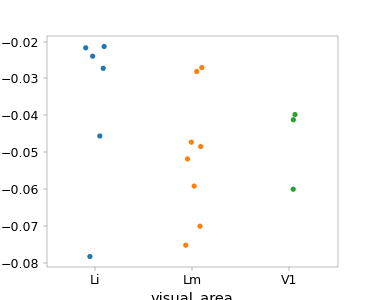

<AxesSubplot:xlabel='visual_area', ylabel='coef'>

In [269]:
fig, ax =pl.subplots()
sns.stripplot(x='visual_area', y='coef', data=pass_reg, ax=ax)

# Split arousal

In [126]:
curr_dst_dir = os.path.join(dst_dir, 'split_pupil')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC/split_pupil


In [127]:
trial_epoch = 'plushalf'
overlap_thr=None
C_value=None
response_type='dff'
responsive_test='ROC'


In [128]:
importlib.reload(p3)

<module 'py3utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/py3utils.py'>

In [129]:
arousal_colors = {'high': 'm', 'low': 'c'}
dashes=['', (1, 1)]
#markers={True:'o', False:'o'}
#parnames = ['threshold', 'width', 'thr', 'slope', 'lambda', 'eta']

In [130]:
va = 'V1'
dk = '20190616_JC097_fov1'

session, animalid, fovnum = p3.split_datakey_str(dk)
sdf = SDF[dk].copy()
configs = sdf.index.tolist()

# Load split_pupil input
curr_id = p3.decode_analysis_id(visual_area=va, prefix='split_pupil', response_type=response_type, 
                    responsive_test=responsive_test, overlap_thr=overlap_thr, trial_epoch=trial_epoch)
res = p3.load_split_pupil_input(animalid, session, fovnum, curr_id=curr_id, traceid=traceid)
if res is None:
    print("--- no results: %s, %s" % (va, dk))

# Group by iteration
in_trials = res['input_trials'].copy()
in_neural = res['neuraldf'].copy()
in_pupil = res['pupildf'].copy()


# Orig ndata
curr_rois = [r for r in in_neural.columns if p3.isnumber(r)]
#print(len(curr_rois))
ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk) 
               & (NDATA['cell'].isin(curr_rois))].copy()


In [131]:
pass_datakeys = [(v, k) for (v, k), g in passdf_drop.groupby(['visual_area', 'datakey'])]

ND = pd.concat([g for (v, k), g in NDATA.groupby(['visual_area', 'datakey']) \
                    if (v, k) in pass_datakeys])
ND.head()

,datakey,config,trial,visual_area,cell,response
0,20190315_JC070_fov1,config049,1,Li,113,0.073911
1,20190315_JC070_fov1,config019,2,Li,113,0.018610
2,20190315_JC070_fov1,config045,3,Li,113,0.029949
3,20190315_JC070_fov1,config021,4,Li,113,0.000708
4,20190315_JC070_fov1,config047,5,Li,113,0.001993


In [132]:
do_iters=False
t_=[]
for (va, dk), nd in NDATA.groupby(['visual_area', 'datakey']):
    print(va, dk)
    in_trials=None; in_neural=None;
    session, animalid, fovnum = p3.split_datakey_str(dk)
    sdf = SDF[dk].copy()
    configs = sdf.index.tolist()

    # Load split_pupil input
    curr_id = p3.decode_analysis_id(visual_area=va, prefix='split_pupil', response_type=response_type, 
                        responsive_test=responsive_test, overlap_thr=overlap_thr, trial_epoch=trial_epoch)
    res = p3.load_split_pupil_input(animalid, session, fovnum, curr_id=curr_id, traceid=traceid)
    if res is None:
        print("... no results: %s, %s" % (va, dk))
        continue
    try:
        # Group by iteration
        in_trials = res['input_trials'].copy()
        in_neural = res['neuraldf'].copy()
        curr_rois = [r for r in in_neural.columns if p3.isnumber(r)]
        ndf = nd[(nd['cell'].isin(curr_rois))].copy()
        
        
        ndf['response'] = ndf['response'] - ndf.groupby(['cell'])['response'].transform('min')

        assert in_trials is not None, "No data"
    except Exception as e:
        print("... ERR: %s, %s" % (va, dk))
        continue
    
    d_=[]
    for (arous_, shuff_), ctrials in in_trials.groupby(['arousal', 'true_labels']):
        ndf['arousal'] = None
        ndf['true_labels'] = None
        xd = ndf[ndf['trial'].isin(ctrials['trial'].values)].copy()
        
        if not do_iters:
            x0 = xd.drop_duplicates()
            tmp = calculate_indices_for_neuraldf(x0, sdf).reset_index()
#             tmp = x0.groupby(['arousal', 'true_labels'])\
#                         .apply(calculate_indices_for_neuraldf, sdf, offset=False).reset_index()
        else:
            tmp = pd.concat([calculate_indices_for_neuraldf(xd[xd['trial'].isin(g['trial'])], \
                                                         sdf, iternum=i)\
                        for i, g in ctrials[ctrials['iteration']<50].groupby(['iteration'])]).reset_index()
        tmp['arousal'] = arous_
        tmp['true_labels']= shuff_

        d_.append(tmp)
    tmpdf = pd.concat(d_, axis=0)
    tmpdf['visual_area'] = va
    tmpdf['datakey'] = dk
    
    if tmpdf['size_tol'].min()<0 or tmpdf['size_tol'].max()>1:
        print("funky ST: (%s, %s)" % (va, dk))
    if tmpdf['morph_ix'].min()<0 or tmpdf['morph_ix'].max()>1:
        print("funky MX: (%s, %s)" % (va, dk))
    t_.append(tmpdf)
iterdf = pd.concat(t_, axis=0) #.reset_index(drop=True)
print(iterdf[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


Li 20190314_JC070_fov1
... ERR: Li, 20190314_JC070_fov1
Li 20190315_JC070_fov1
... no results: Li, 20190315_JC070_fov1
Li 20190316_JC070_fov1


Traceback (most recent call last):
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/py3utils.py", line 45, in load_split_pupil_input
    assert len(curr_inputfiles)==1, "More than 1 input file: %s" % str(curr_inputfiles)
AssertionError: More than 1 input file: []


Li 20190319_JC067_fov1
... ERR: Li, 20190319_JC067_fov1
Li 20190320_JC067_fov1
Li 20190321_JC070_fov1
Li 20190322_JC073_fov1
Li 20190327_JC073_fov1
... ERR: Li, 20190327_JC073_fov1
Li 20190422_JC076_fov1
Li 20190602_JC091_fov1
Li 20190606_JC091_fov1
Li 20190607_JC091_fov1
Li 20190609_JC099_fov1
Li 20190612_JC099_fov1
Li 20190614_JC091_fov1
Li 20190617_JC099_fov1
Li 20191018_JC113_fov1
... ERR: Li, 20191018_JC113_fov1
Li 20191105_JC117_fov1
Li 20191111_JC120_fov1
Lm 20190322_JC073_fov1
Lm 20190327_JC073_fov1
Lm 20190422_JC076_fov1
Lm 20190430_JC078_fov1
Lm 20190504_JC078_fov1
Lm 20190506_JC080_fov1
Lm 20190508_JC083_fov1
Lm 20190509_JC078_fov1
Lm 20190512_JC083_fov1
Lm 20190513_JC078_fov1
Lm 20190517_JC083_fov1
Lm 20190525_JC084_fov1
Lm 20190603_JC080_fov1
Lm 20190618_JC097_fov1
Lm 20190627_JC091_fov1
Lm 20191105_JC117_fov1
Lm 20191111_JC120_fov1
V1 20190420_JC076_fov1
V1 20190501_JC076_fov1
V1 20190504_JC078_fov1
V1 20190507_JC083_fov1
V1 20190508_JC083_fov1
V1 20190509_JC078_fov1
V1 2

In [133]:
iterdf.groupby(['arousal', 'true_labels']).min()

cell  size_tol  morph_ix  sparseness visual_area  \
arousal true_labels                                                     
high    False           0  0.304296  0.025547    0.000566          Li   
        True            0  0.201544  0.043766    0.001003          Li   
low     False           0  0.304296  0.025547    0.000566          Li   
        True            0  0.274515  0.026070    0.000710          Li   

                                 datakey  
arousal true_labels                       
high    False        20190316_JC070_fov1  
        True         20190316_JC070_fov1  
low     False        20190316_JC070_fov1  
        True         20190316_JC070_fov1

In [136]:
print(iterdf[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


             datakey  cell
visual_area               
Li               540   540
Lm              1101  1101
V1              1251  1251


In [135]:

valdf = pd.concat([g for (v, k, c), g in iterdf.groupby(['visual_area', 'datakey', 'cell']) 
        if (0<=g['size_tol'].min()<=1) & (0<=g['size_tol'].max()<=1)
         & (0<=g['morph_ix'].min()<=1) & (0<=g['morph_ix'].max()<=1)])

print(valdf[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


# df_ = df.dropna()

             datakey  cell
visual_area               
Li               540   540
Lm              1101  1101
V1              1251  1251


In [137]:
counts=iterdf.groupby(["visual_area","arousal", 'true_labels']).size()


In [138]:
drop_repeats_by = 'most_cells'
drop_repeats = True
dset_str = 'drop_repeats_%s' % drop_repeats_by if drop_repeats else 'alldata'

# Drop repeat FOVs
min_ncells = 10

# Select by most N cells
# unique_dsets = p3.select_best_fovs(CELLS) #, criterion='max', colname='cell')
# unique_dkeys = [(v, k) for (v, k), g in unique_dsets.groupby(['visual_area', 'datakey'])]

excl_dsets = [] #['20190501_JC076_fov1', '20190627_JC091_fov1'] #['20190507_JC083_fov1'] #, '20190501_JC076_fov1'] #, '20190617_JC099_fov1'] #'20191018_JC113_fov1']

df = pd.concat([g for (v, k), g in valdf.groupby(['visual_area', 'datakey'])\
                        if (v, k) in pass_datakeys and k not in excl_dsets])


print("Drop repeats:")
print(df[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())


Drop repeats:
             datakey
visual_area         
Li                 7
Lm                 9
V1                 9


In [139]:
arousal_colors = {'high': 'magenta', 'low': 'cyan'}

<IPython.core.display.Javascript object>


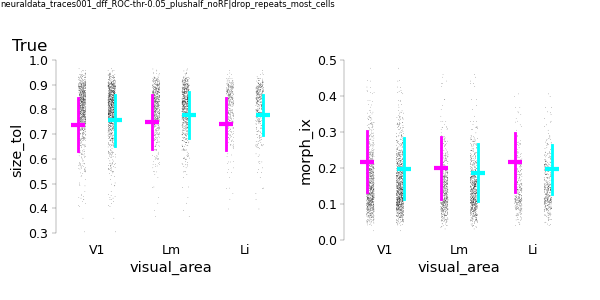

In [140]:
pars = ['size_tol', 'morph_ix'] #, 'sparseness']
plot_type='POINT'
ci='sd'

fig, axn = pl.subplots(1, len(pars), figsize=(8,4), sharex=True, sharey=False)

for pi, par in enumerate(pars):
    ax=axn[pi]
    if plot_type=='BOX':
        sns.boxplot(x='visual_area', y=par, data=df[df['true_labels']==True], ax=ax, 
                      hue='arousal', order=visual_areas, palette=arousal_colors, 
                      dodge=0.5, zorder=-1, notch=True, fliersize=0, whis=[5, 95])
    else:
        sns.pointplot(x='visual_area', y=par, data=df[df['true_labels']==True], ax=ax, dodge=0.5,ci=ci,
                     hue='arousal', palette=arousal_colors, 
                      order=visual_areas, scale=2, markers='_', join=False)
        
    sns.stripplot(x='visual_area', y=par, data=df[df['true_labels']==False], ax=ax, 
                  hue='arousal', order=visual_areas, #palette=arousal_colors, 
                  dodge=0.5, color='k', size=0.5, zorder=-1)
    ax.legend_.remove()
    if par=='size_tol':
        ax.set_yticks(np.linspace(0.3, 1, 8))
    else:
        ax.set_yticks(np.linspace(0, 0.5, 6))
for ax in axn.flat:
    sns.despine(bottom=True, offset=4, ax=ax, trim=True)
    ax.tick_params(which='both', axis='x', size=0)
    
fig.text(0.02, 0.83, 'True', fontsize=16)

p3.label_figure(fig, '%s|%s' % (data_id, dset_str))

pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.3, hspace=0.5)

pl.savefig(os.path.join(dst_dir, 'split_pupil', 'ST_MX_truelabels_%s_hi_lo_%s__%s.svg' % (plot_type, par, dset_str)))


<IPython.core.display.Javascript object>


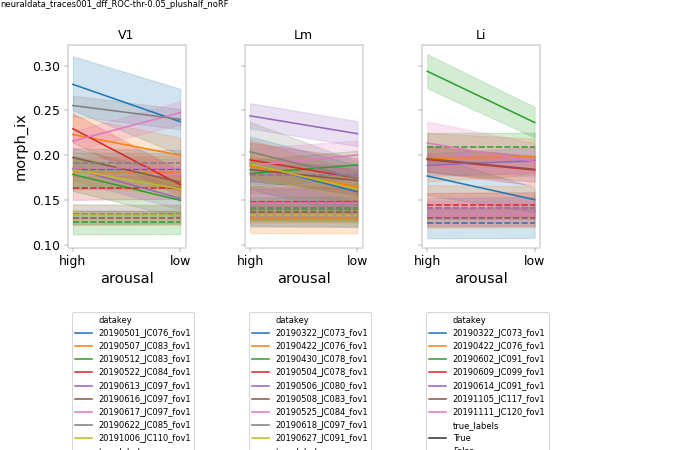

In [142]:
fig, axn = pl.subplots(1, 3,  figsize=(9,6), sharex=True, sharey=True)

for va, vg in df.groupby(['visual_area']):
    ai = visual_areas.index(va)
    ax=axn[ai]
    sns.lineplot(x='arousal', y=par, data=vg, ax=ax,
                hue='datakey', color='k', err_style='band', style='true_labels', style_order=[True, False])
    ax.legend(bbox_to_anchor=(0, -0.3), loc='upper left', fontsize=8)
    ax.set_title(va)
    
pl.subplots_adjust(bottom=0.45, top=0.9, left=0.1, right=0.8, wspace=0.5)
p3.label_figure(fig, data_id)

pl.savefig(os.path.join(curr_dst_dir, 'all_animals__%s.svg' % dset_str))

#### SPLIT_PUPIL:  fov means

In [143]:
pupil_means_by_fov = df.groupby(['visual_area', 'datakey', 'arousal', 'true_labels']).mean().reset_index()
pupil_means_by_fov

,visual_area,datakey,arousal,true_labels,cell,size_tol,morph_ix,sparseness
0,Li,20190322_JC073_fov1,high,False,219.473684,0.838459,0.124183,0.006108
1,Li,20190322_JC073_fov1,high,True,219.473684,0.771564,0.176817,0.010906
2,Li,20190322_JC073_fov1,low,False,219.473684,0.838459,0.124183,0.006108
3,Li,20190322_JC073_fov1,low,True,219.473684,0.799136,0.150372,0.008957
4,Li,20190422_JC076_fov1,high,False,245.172414,0.793837,0.141089,0.013069
...,...,...,...,...,...,...,...,...
95,V1,20190622_JC085_fov1,low,True,206.622449,0.714227,0.240129,0.027652
96,V1,20191006_JC110_fov1,high,False,191.220930,0.806828,0.133063,0.011271
97,V1,20191006_JC110_fov1,high,True,191.220930,0.742485,0.183672,0.019608
98,V1,20191006_JC110_fov1,low,False,191.220930,0.806828,0.133063,0.011271


In [144]:
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC


MEANS:
  visual_area arousal  size_tol  morph_ix  size_tol_std  morph_ix_std
0          Li    high  0.745287  0.208702      0.041890      0.039055
1          Li     low  0.783315  0.191401      0.021473      0.025455
2          Lm    high  0.751631  0.195926      0.027567      0.019230
3          Lm     low  0.785281  0.179906      0.027638      0.021131
4          V1    high  0.732526  0.216414      0.028109      0.034488
5          V1     low  0.759502  0.191777      0.031999      0.040180


<IPython.core.display.Javascript object>


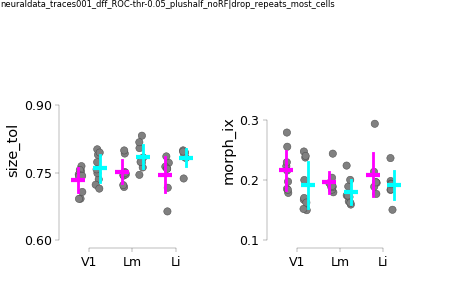

Wilcoxon signed-rank test
___________________size_tol
   t_stat  p_val visual_area
0     3.0  0.020          V1
1     1.0  0.008          Lm
2     0.0  0.016          Li
Wilcoxon signed-rank test
___________________morph_ix
   t_stat  p_val visual_area
0     6.0  0.055          V1
1     3.0  0.020          Lm
2     3.0  0.078          Li
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC splitpupil_ST_MX_dff_byFOV_fdr_bh__drop_repeats_most_cells_noRF


In [146]:
plot_cells=False
multi_comp_test='fdr_bh' #'fdr_bh'
bw = True

plot_params=['size_tol', 'morph_ix']
plot_str = 'byCELL' if plot_cells else 'byFOV' 
curr_colors = bw_area_colors if bw else area_colors

plotdf = pupil_means_by_fov[(pupil_means_by_fov['true_labels']==True)].copy()
p3.print_means(plotdf, groupby=['visual_area', 'arousal'], params=plot_params)


fig, axn = pl.subplots(1, len(plot_params), figsize=(len(plot_params)*3, 4))
ax=axn[0]

for ai, metric in enumerate(['size_tol', 'morph_ix']):
    ax=axn[ai]
    sns.stripplot(x='visual_area', y=metric, data=plotdf, ax=ax, size=7,
                 order=visual_areas, zorder=-1, hue='arousal', palette=['gray']*3, dodge=0.5,
                 edgecolor='gray', facecolor='white', linewidth=0.5, jitter=True)
    
    sns.pointplot(x='visual_area', y=metric, data=plotdf, ax=ax,
                  order=visual_areas, join=False, dodge=0.5, ci='sd',
                  hue='arousal', palette=arousal_colors, markers='_', scale=2, zorder=-1)
    ax.legend_.remove()
    if metric=='size_tol':
        y_loc = 0.9 #0.9
        offset = 0.035
    else:
        y_loc = 0.35 if plot_cells else 0.2
        offset = 0.02 if plot_cells else 0.035
        
    if metric=='size_tol' and plot_cells is False:
        ax.set_ylim([0.6, 1])
        ax.set_yticks(np.linspace(0.6, 0.9, 3))
    elif metric=='morph_ix' and plot_cells is False:
        ax.set_ylim([0.1, 0.4])
        ax.set_yticks(np.linspace(0.1, .3, 3))
    else:
        ax.set_ylim([0, 0.25])
    print("Wilcoxon signed-rank test")
    print("___________________%s" % metric)
    statdf = p3.paired_ttests(plotdf, metric=metric, round_to=3,
                    c1='high', c2='low', compare_var='arousal', ttest=False)
    print(statdf)


sns.despine(offset=8, trim=True)
pl.subplots_adjust(bottom=0.2, left=0.15, right=0.9, top=0.8, wspace=0.6)
#p3.crop_legend_labels(ax, n_hues=3, bbox_to_anchor=(1, 1), loc='upper left') #title='pass(p<%.2f)' % p_thr)

for ax in axn.flat:
    ax.set_xlabel('')
    
p3.label_figure(fig, '%s|%s' % (data_id, dset_str))


figname = 'splitpupil_ST_MX_%s_%s_%s__%s_%s' % (response_type, plot_str, multi_comp_test, dset_str, overlap_str)
pl.savefig(os.path.join(dst_dir, 'split_pupil', '%s.svg' % figname))
print(dst_dir, figname)

#### SPLIT_PUPIL:  plot byFOV, PAIRED

             true_labels        cell  size_tol  morph_ix  sparseness
visual_area                                                         
Li                   0.5  168.942253  0.788369  0.173203    0.013127
Lm                   0.5  141.806418  0.786945  0.165763    0.013272
V1                   0.5  172.728106  0.768018  0.181428    0.019165


<IPython.core.display.Javascript object>


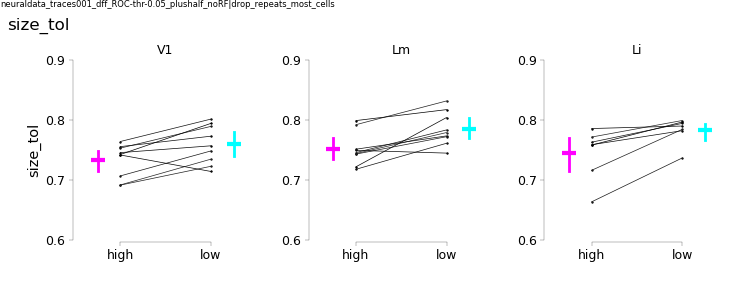

___________________size_tol
   t_stat  p_val visual_area
0     3.0  0.020          V1
1     1.0  0.008          Lm
2     0.0  0.016          Li
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC paired_size_tol__dff_byfov__drop_repeats_most_cells_noRF


<IPython.core.display.Javascript object>


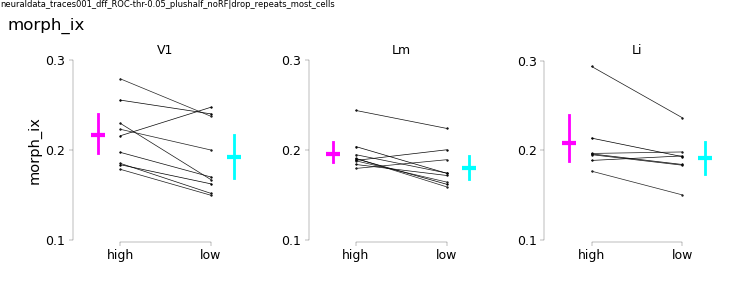

___________________morph_ix
   t_stat  p_val visual_area
0     6.0  0.055          V1
1     3.0  0.020          Lm
2     3.0  0.078          Li
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC paired_morph_ix__dff_byfov__drop_repeats_most_cells_noRF


In [276]:
plot_cells=False
multi_comp_test='fdr_bh' #'fdr_bh'

plot_params = ['size_tol', 'morph_ix']

plot_str = 'bycell' if plot_cells else 'byfov'
plotdf = df.copy() if plot_cells else pupil_means_by_fov.copy()
print(plotdf.groupby(['visual_area']).mean())


for metric in plot_params:
    fig, axn = pl.subplots(1, 3,  figsize=(10,4))
    for va, vg in plotdf[plotdf.true_labels==True].groupby(['visual_area']):
        ai = visual_areas.index(va)
        ax=axn[ai]
        ax.set_title(va,fontsize=12)
        sns.pointplot(x='arousal', y=metric, data=vg, ax=ax,
                     hue='datakey', color='k', scale=0.25)

        sns.pointplot(x='arousal', y=metric, data=vg, ax=ax,
                     hue='arousal', palette=arousal_colors, order=['high', 'low'], join=False, 
                     markers='_', scale=2, dodge=0.5)

        if metric=='size_tol':
            y_loc = 0.94 #0.9
            offset = 0.035
        else:
            y_loc = 0.35 if plot_cells else 0.2
            offset = 0.02 if plot_cells else 0.02
        if metric=='size_tol':
            ax.set_yticks(np.linspace(0.6, 0.9, 4)) #[0.6, .9])
        else:
            ax.set_yticks(np.linspace(0.1, 0.3, 3))
        if ai!=0:
            ax.set_xlabel('')
            ax.set_ylabel('')
        ax.legend_.remove()

    df_ = plotdf[plotdf.true_labels==True].copy()
    print("___________________%s" % metric)
    statdf = p3.paired_ttests(df_, metric=metric, round_to=3,
                    c1='high', c2='low', compare_var='arousal', ttest=False)
    print(statdf)


    sns.despine(offset=2, trim=True)
    pl.subplots_adjust(bottom=0.2, left=0.1, right=0.97, top=0.8, wspace=0.3)

    for ax in axn.flat:
        ax.set_xlabel('')
    fig.text(0.01, 0.9, metric, fontsize=16)
    p3.label_figure(fig, '%s|%s' % (data_id, dset_str))

    figname = 'paired_%s__%s_%s__%s_%s' % (metric, response_type, plot_str, dset_str, overlap_str)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

<IPython.core.display.Javascript object>


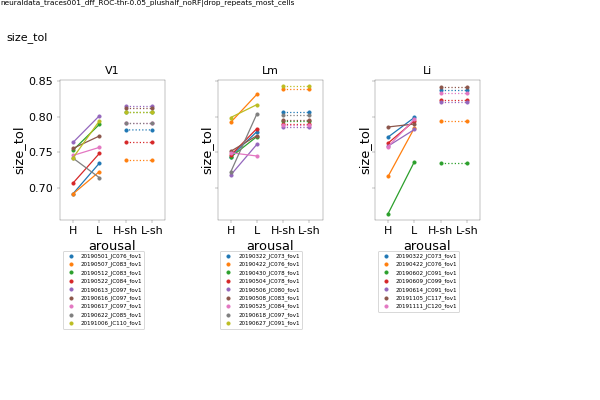

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC/split_pupil size_tol_splitpupil_paired_byFOV__drop_repeats_most_cells


<IPython.core.display.Javascript object>


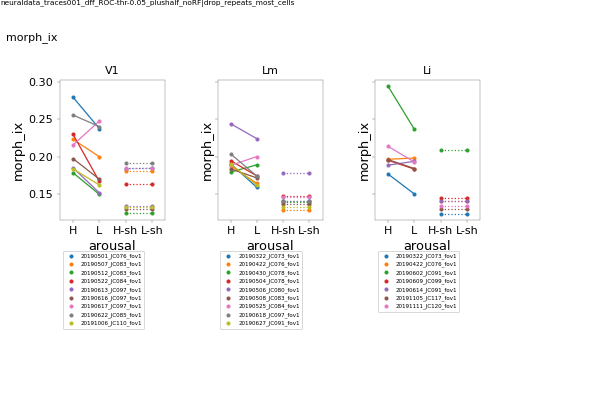

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC/split_pupil morph_ix_splitpupil_paired_byFOV__drop_repeats_most_cells


In [853]:
metric='size_tol'
#plotd = passcorrs.copy()
for  metric in ['size_tol', 'morph_ix']:

    fig, axn = pl.subplots(1, 3, figsize=(9,6), sharey=True)

    for va, plotd in plotdf.groupby(['visual_area']):

        ai = visual_areas.index(va)
        ax=axn[ai]

        curr_hue_order = sorted(plotd['datakey'].unique())
        # True arousal labels
        sns.pointplot(x='arousal', y=metric, hue='datakey', ax=ax,
                      data=plotd[plotd.true_labels==True],
                     hue_order=curr_hue_order, order=['high', 'low', 'high_shuff', 'low_shuff'], 
                     scale=0.5, ci=None)

        # Shuffled arousal labels
        sns.pointplot(x='arousal', y=metric, hue='datakey', ax=ax,
                      data=plotd[plotd.true_labels==False],
                      linestyles=':',hue_order=curr_hue_order, order=['high_shuff', 'low_shuff', 'high', 'low'],
                      scale=0.5, ci=None)
        ax.set_xticklabels(['H', 'L', 'H-sh', 'L-sh'])
        nrats = len(curr_hue_order)
        p3.crop_legend_labels(ax, n_hues=nrats, bbox_to_anchor=(0, -0.2), loc='upper left', fontsize=6)
        ax.set_title(va)
    pl.subplots_adjust(bottom=0.45, top=0.8, left=0.1, right=0.8, wspace=0.5)

    fig.text(0.01, 0.9, '%s' % metric, fontsize=12)
    p3.label_figure(fig, '%s|%s' % (data_id, dset_str))

    figname = '%s_splitpupil_paired_byFOV__%s' % (metric, dset_str)

    pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
    print(curr_dst_dir, figname)

In [383]:

# pars = ['size_tol', 'morph_ix', 'sparseness']

# fig, axn = pl.subplots(2, len(pars), figsize=(8,5))

# for pi, par in enumerate(pars):
#     ax=axn[0, pi]

#     sns.violinplot(x='visual_area', y=par, data=df[df['true_labels']==True], ax=ax, 
#                   hue='arousal', linestyles='-', order=visual_areas, palette=arousal_colors, 
#                   dodge=0.5, split=True,  inner="quartile", scale_hue=False,  scale="count")
    
#     ax=axn[1, pi]
#     sns.pointplot(x='visual_area', y=par, data=df[df['true_labels']==False], ax=ax, 
#                   hue='arousal', linestyles=':', order=visual_areas, palette=arousal_colors, dodge=0.5, join=False)
# pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.5, hspace=0.5)

In [225]:
os.listdir(curr_dst_dir)

['cdf_hi_lo_size_tol.svg',
 'cdf_hi_lo_morph_ix.svg',
 'avg_params_hi_lo_sparseness.svg',
 'avg_params_hi_lo_morph_ix.svg',
 'avg_params_BOX_hi_lo_morph_ix.svg',
 'all_animals.svg',
 'tradeoff_pearsons_corrcoef__allanimals.svg',
 'tradeoff_pearsons_corrcoef_byFOV__allanimals.svg',
 'avg_params_BOX_hi_lo_morph_ix__drop_repeats_most_cells.svg',
 'all_animals__drop_repeats_most_cells.svg',
 'size_tol_splitpupil_paired_byFOV__drop_repeats_most_cells.svg',
 'tradeoff_pearsons_corrcoef_byFOV__drop_repeats_most_cells.svg',
 'tradeoff_pearsons_corrcoef__drop_repeats_most_cells.svg',
 'morph_ix_splitpupil_paired_byFOV__drop_repeats_most_cells.svg',
 'paired_tradeoff_pearsons_r__dff_byfov__drop_repeats_most_cells_noRF.svg',
 'avg_params_POINT_hi_lo_morph_ix__drop_repeats_most_cells.svg',
 'ST_MX_truelabels_POINT_hi_lo_morph_ix__drop_repeats_most_cells.svg',
 'splitpupil_ST_MX_dff_byFOV_fdr_bh__drop_repeats_most_cells_noRF.svg',
 'splitpupil_tradeoff_pearsonsR_TRUEonly__drop_repeats_most_cells.sv

<IPython.core.display.Javascript object>


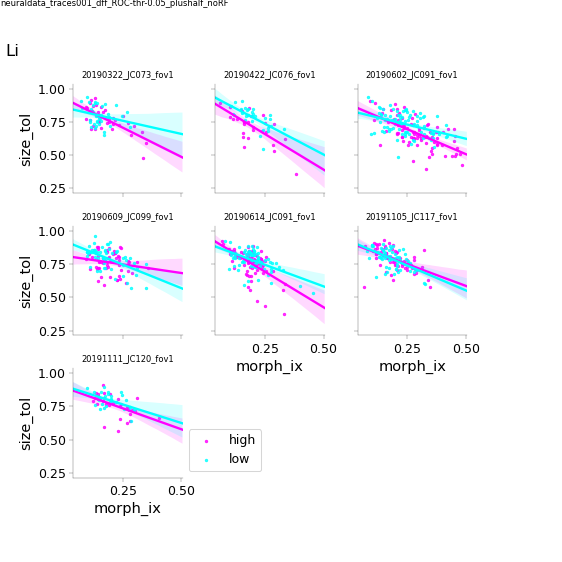

<IPython.core.display.Javascript object>


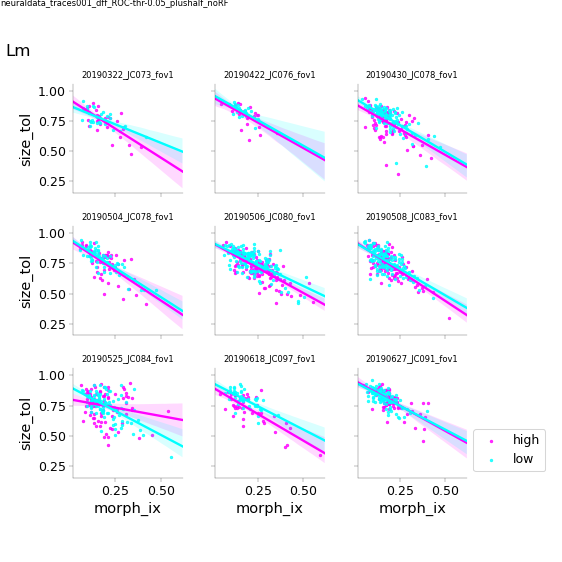

<IPython.core.display.Javascript object>


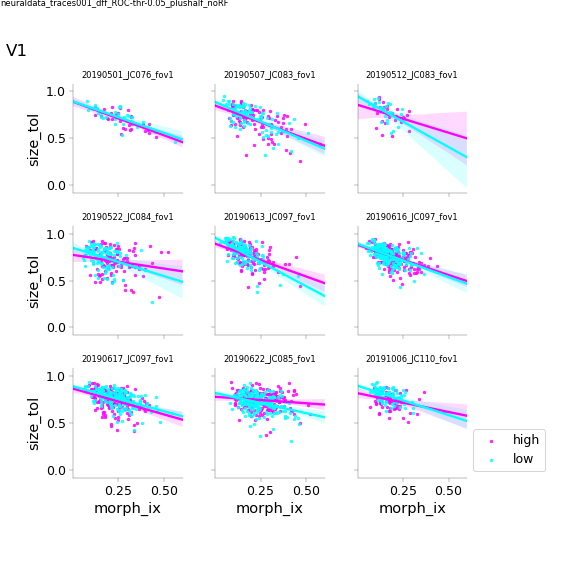

In [229]:
for va, ixs_ in df[df.true_labels].groupby(['visual_area']):
    #ixs_ = df[(df.visual_area==va) & (df.true_labels)].copy()
    fg = sns.lmplot(x='morph_ix', y='size_tol', hue='arousal', data=ixs_, 
              palette=arousal_colors, height=2.5, truncate=False, col='datakey', col_wrap=3, legend=False,
                   scatter_kws={'s': 5})
    fg.set_titles("{col_name}", size=8)
    pl.legend(bbox_to_anchor=(1,0), loc='lower left')
    pl.subplots_adjust(left=0.13, right=0.83, top=0.85, bottom=0.15, wspace=0.3, hspace=0.3)

    fg.fig.text(0.01, 0.9, va, fontsize=16)
    p3.label_figure(fg.fig, data_id)

    pl.savefig(os.path.join(curr_dst_dir, 'REGR_splitpupil_%s.svg' % va))


In [231]:
curr_dst_dir


'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC/split_pupil'

In [148]:
min_ncells = 10

c_=[]
for (va, dk, arous_, tru_), ixs_ in df.groupby(['visual_area', 'datakey', 'arousal', 'true_labels']):
    if len(ixs_) <= 1:
        print("... n=1 cell: %s, %s" % (va, dk))
        continue
        
    for sel_type in ['morph_ix', 'sparseness']:
        pearsons_r, pearsons_p = spstats.pearsonr(ixs_['size_tol'], ixs_[sel_type])

        regr = make_pipeline(StandardScaler(), RidgeCV(alphas=np.logspace(-10, 10, 21)))
        X = ixs_[['morph_ix']].copy()
        y = ixs_['size_tol'].copy()
        regr.fit(X, y)
        y_pred = regr.predict(X)
        y_test = copy.copy(y)

        # metrics
        pearsons_r, pearsons_p = spstats.pearsonr(X.values[:, 0], y)
        R2 = skmetrics.r2_score(y_test, y_pred)
        if R2<0:
            print("Bad fit: %s (R2=%.2f)" % (datakey, R2))

        MSE = skmetrics.mean_squared_error(y_test, y_pred)
        MAE = skmetrics.median_absolute_error(y_test, y_pred)
        
        B0=float(regr.named_steps['ridgecv'].coef_)
        B1=float(regr.named_steps['ridgecv'].intercept_)

        res = pd.Series({'pearsons_r': float(pearsons_r), 'pearsons_p': float(pearsons_p), 
               'R2': R2, 'MSE': MSE, 'MAE': MAE, 
               'coef': B0, 'intercept': B1, 'selectivity': sel_type,
               'visual_area': va, 'datakey': dk, 'n_cells': len(ixs_['cell'].unique()),
              'arousal': arous_, 'true_labels': tru_})
      
#         c = pd.Series({'selectivity': sel_type, 
#                        'pearsons_p': pearsons_p, 'pearsons_r': pearsons_r,
#                        'visual_area': va, 'datakey': dk, 'n_cells': len(ixs_),
#                        'arousal': arous_, 'true_labels': tru_})
        c_.append(res)


corrs = pd.concat(c_, axis=1).T

p_thr=0.05
corrs['pass'] = corrs['pearsons_p'] < p_thr

print(corrs[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

corrs['true_labels'].unique()



             datakey
visual_area         
Li                 7
Lm                 9
V1                 9


array([False, True], dtype=object)

In [158]:
cols = ['pearsons_p', 'pearsons_r', 'visual_area', 'datakey', 'n_cells', 'arousal', 'true_labels']

corrdf = corrs[corrs['selectivity']=='morph_ix'].copy() #groupby(['visual_area', 'datakey'])

In [160]:
passcorrs = pd.concat([g for (va, dk), g in corrdf.groupby(['visual_area', 'datakey']) \
           if any(g[g['true_labels']==True]['pearsons_p']<0.05)])


MEANS:
MEANS:
  visual_area arousal  pearsons_r  pearsons_r_std
0          Li    high   -0.504576        0.190404
1          Li     low   -0.482966        0.170204
2          Lm    high   -0.615943        0.182709
3          Lm     low   -0.641309        0.149361
4          V1    high   -0.377061        0.193694
5          V1     low   -0.447174        0.198318


<IPython.core.display.Javascript object>


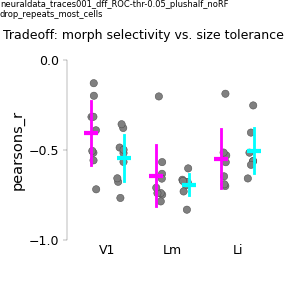

Wilcoxon signed-rank test:
   t_stat  p_val visual_area  true_labels
0     1.0  0.008          V1         True
1    17.0  0.570          Lm         True
2    11.0  0.688          Li         True
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC/split_pupil splitpupil_tradeoff_pearsonsR_TRUEonly__drop_repeats_most_cells


In [161]:
passcorrs = corrdf.copy()
metric = 'pearsons_r'

passcorrs[metric] = passcorrs[metric].astype(float)
print("MEANS:")

p3.print_means(passcorrs, groupby=['visual_area', 'arousal'], params=['pearsons_r'])
# fig, axn = pl.subplots(1,2, figsize=(8,4), sharex=True, sharey=True)
# ax=axn[0]
fig, ax = pl.subplots(figsize=(4,4), sharex=True, sharey=True)

# sns.stripplot(x='visual_area', y=metric, data=plotdf, ax=ax, size=10,
#              order=visual_areas, zorder=-1, hue='arousal', palette=['w', 'w', 'w'], dodge=0.5,
#              edgecolor='gray', facecolor='white', linewidth=1, jitter=True)

# sns.pointplot(x='visual_area', y=metric, data=plotdf, ax=ax,
#               order=visual_areas, join=False, dodge=0.5,
#               hue='arousal', palette=arousal_colors,
#              markers='_', scale=2, zorder=-1)

sns.stripplot(x='visual_area', y='pearsons_r', data=passcorrs[passcorrs.true_labels==True], ax=ax,
              size=7, order=visual_areas, zorder=-1, hue='arousal', palette=['gray']*3, dodge=0.5,
                 edgecolor='gray', facecolor='white', linewidth=0.5, jitter=True)
    
sns.pointplot(x='visual_area', y='pearsons_r', data=passcorrs[passcorrs.true_labels==True], ax=ax,
             order=visual_areas, hue='arousal', palette=arousal_colors, dodge=0.5, join=False, 
              markers='_', scale=2, zorder=-1, ci='sd')

ax.legend_.remove()

ax.set_ylim([-1, 0])
ax.set_yticks(np.linspace(-1, 0, 3))
sns.despine(bottom=True, offset=8, trim=True)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')

y_loc=-0.2
offset=0.05
df_ = passcorrs[(passcorrs['true_labels']==True)].copy()
s1 = p3.paired_ttests(df_, metric=metric, round_to=3,
                c1='high', c2='low', compare_var='arousal', ttest=False)
s1['true_labels'] = True
print("Wilcoxon signed-rank test:")
print(s1)

# ax=axn[1]
# sns.pointplot(x='visual_area', y='pearsons_r', data=passcorrs[passcorrs.true_labels==False], ax=ax,
#              order=visual_areas, hue='arousal', palette=arousal_colors, dodge=0.5, join=False, 
#               markers='_', scale=2)
# sns.stripplot(x='visual_area', y='pearsons_r', data=passcorrs[passcorrs.true_labels==False], ax=ax,
#              order=visual_areas, hue='arousal',  dodge=0.5, color='k', size=5, marker='o')

# p3.crop_legend_labels(ax, n_hues=2, bbox_to_anchor=(1,1), loc='lower right')
# ax.set_title("Shuffled labels", loc='left')

# df_ = passcorrs[(passcorrs['true_labels']==False)].copy()
# # s2 = p3.paired_ttests(df_, metric=metric, round_to=3,
# #                 c1='high', c2='low', compare_var='arousal', ttest=False)
# # s2['true_labels'] = False
# # statdf= pd.concat([s1, s2])


fig.text(0.01, 0.87, 'Tradeoff: morph selectivity vs. size tolerance', fontsize=12)

p3.label_figure(fig, '%s\n%s' % (data_id, dset_str))
pl.subplots_adjust(left=0.25, right=0.9, top=0.8, bottom=0.2)


figname = 'splitpupil_tradeoff_pearsonsR_TRUEonly__%s' % (dset_str)

pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

#### SPLIT_PUPIL:  Pearons's R, PAIRED

<IPython.core.display.Javascript object>


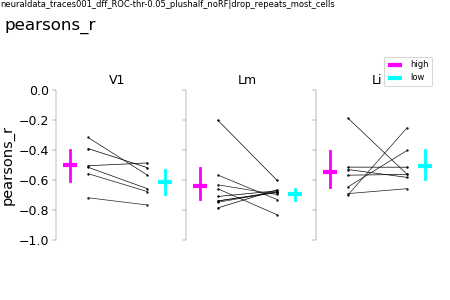

___________________pearsons_r
   t_stat  p_val visual_area
0     1.0  0.062          V1
1    17.0  0.570          Lm
2    11.0  0.688          Li
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC paired_tradeoff_pearsons_r__dff_byFOV__drop_repeats_most_cells_noRF


In [183]:
metric = 'pearsons_r'

fig, axn = pl.subplots(1, 3,  figsize=(6,4), sharex=True, sharey=True)

for va, vg in passcorrs[passcorrs.true_labels==True].groupby(['visual_area']):
    ai = visual_areas.index(va)
    ax=axn[ai]
    ax.set_title(va,fontsize=12)
    sns.pointplot(x='arousal', y=metric, data=vg, ax=ax,
                 hue='arousal', palette=arousal_colors, order=['high', 'low'], join=False, 
                 markers='_', scale=2, dodge=0.6)
    sns.pointplot(x='arousal', y=metric, data=vg, ax=ax,
                 hue='datakey', color='k', scale=0.25)


    y_loc = 0.35 if plot_cells else 0.2
    offset = 0.02 if plot_cells else 0.02
    ax.set_yticks(np.linspace(-1, 0, 6)) #[0.6, .9])
    ax.set_ylim([-1, 0])

    if ai!=0:
        ax.set_xlabel('')
        ax.set_ylabel('')
    ax.legend_.remove()
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xticklabels([])

p3.crop_legend_labels(axn[-1], n_hues=2, bbox_to_anchor=(1, 1), loc='lower right', fontsize=8) #.remove()
df_ = passcorrs[passcorrs.true_labels==True].copy()
print("___________________%s" % metric)
statdf = p3.paired_ttests(df_, metric=metric, round_to=3,
                c1='high', c2='low', compare_var='arousal', ttest=False)
print(statdf)

sns.despine(offset=2, trim=True, bottom=True)
pl.subplots_adjust(bottom=0.2, left=0.13, right=0.97, top=0.7, wspace=0.1)

for ax in axn.flat:
    ax.set_xlabel('')
fig.text(0.01, 0.9, metric, fontsize=16)
p3.label_figure(fig, '%s|%s' % (data_id, dset_str))

figname = 'paired_tradeoff_%s__%s_%s__%s_%s' % (metric, response_type, plot_str, dset_str, overlap_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [249]:
print(corrdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

passcorrs = pd.concat([g for (va, dk), g in corrdf.groupby(['visual_area', 'datakey']) \
           if #any(g[g['true_labels']==True]['pearsons_p']<0.05) 
            all(g[g.true_labels]['R2']>=0.05)])
                       #& (g[g.true_labels]['R2']>=0.2)])
print(passcorrs[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())


             datakey
visual_area         
Li                 7
Lm                 9
V1                 9
             datakey
visual_area         
Li                 6
Lm                 8
V1                 7


In [258]:
corrdf[(corrdf.visual_area=='Li') & (corrdf.true_labels)]

,pearsons_r,pearsons_p,R2,MSE,MAE,coef,intercept,selectivity,visual_area,datakey,n_cells,arousal,true_labels,pass
2,-0.700119,0.000001,0.489844,0.003991,0.044852,-0.060338,0.771564,morph_ix,Li,20190322_JC073_fov1,38,high,True,True
6,-0.252371,0.12636,0.060927,0.004776,0.061268,-0.014249,0.799136,morph_ix,Li,20190322_JC073_fov1,38,low,True,False
10,-0.690672,0.000034,0.477028,0.006739,0.053783,-0.078418,0.716108,morph_ix,Li,20190422_JC076_fov1,29,high,True,True
14,-0.657983,0.000105,0.432461,0.003455,0.041553,-0.049624,0.784324,morph_ix,Li,20190422_JC076_fov1,29,low,True,True
18,-0.646451,0.0,0.417845,0.006575,0.053622,-0.06792,0.663534,morph_ix,Li,20190602_JC091_fov1,87,high,True,True
22,-0.40325,0.000108,0.16259,0.005921,0.059644,-0.033524,0.7367,morph_ix,Li,20190602_JC091_fov1,87,low,True,True
26,-0.187484,0.162554,0.034367,0.005536,0.048005,-0.012077,0.763023,morph_ix,Li,20190609_JC099_fov1,57,high,True,False
30,-0.561069,0.000006,0.314705,0.004682,0.044793,-0.045576,0.794314,morph_ix,Li,20190609_JC099_fov1,57,low,True,True
34,-0.567836,0.0,0.322437,0.006888,0.040313,-0.05718,0.758795,morph_ix,Li,20190614_JC091_fov1,78,high,True,True
38,-0.562586,0.0,0.316503,0.0039,0.038359,-0.042507,0.782198,morph_ix,Li,20190614_JC091_fov1,78,low,True,True


In [262]:
params_list=['pearsons_r', 'R2', 'coef']
plotd = passcorrs[passcorrs.true_labels==True].copy()
for p in params_list:
    plotd[p] =plotd[p].astype(float)
p3.print_means(plotd, groupby=['visual_area', 'arousal'],
                                                               params=params_list)

MEANS:
  visual_area arousal  pearsons_r        R2      coef  pearsons_r_std  \
0          Li    high   -0.608263  0.374626 -0.056863        0.081545   
1          Li     low   -0.495576  0.262749 -0.034816        0.145922   
2          Lm    high   -0.697646  0.491192 -0.072613        0.072439   
3          Lm     low   -0.704750  0.499164 -0.055449        0.055031   
4          V1    high   -0.474006  0.241523 -0.046329        0.145139   
5          V1     low   -0.595575  0.364242 -0.057188        0.106346   

     R2_std  coef_std  
0  0.100197  0.015926  
1  0.132909  0.012526  
2  0.098138  0.014204  
3  0.082626  0.015823  
4  0.148018  0.019351  
5  0.131804  0.018715  


<IPython.core.display.Javascript object>


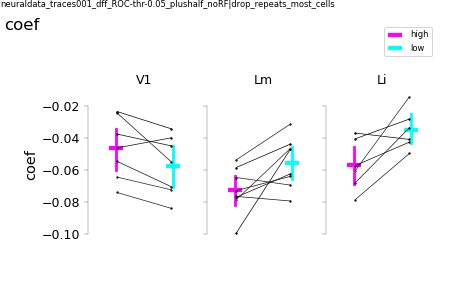

___________________coef
   t_stat  p_val visual_area
0     1.0  0.031          V1
1     3.0  0.039          Lm
2     1.0  0.062          Li
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC paired_tradeoff_coef__dff_byFOV__drop_repeats_most_cells_noRF


In [254]:
metric = 'coef'

fig, axn = pl.subplots(1, 3,  figsize=(6,4), sharex=True, sharey=True)

for va, vg in passcorrs[passcorrs.true_labels==True].groupby(['visual_area']):
    ai = visual_areas.index(va)
    ax=axn[ai]
    ax.set_title(va,fontsize=12)
    sns.pointplot(x='arousal', y=metric, data=vg, ax=ax,
                 hue='arousal', palette=arousal_colors, order=['high', 'low'], join=False, 
                 markers='_', scale=2, dodge=True)
    sns.pointplot(x='arousal', y=metric, data=vg, ax=ax,
                 hue='datakey', color='k', scale=0.25)


#     y_loc = 0.35 if plot_cells else 0.2
#     offset = 0.02 if plot_cells else 0.02
#     ax.set_yticks(np.linspace(-1, 0, 6)) #[0.6, .9])
#     ax.set_ylim([-1, 0])

    if ai!=0:
        ax.set_xlabel('')
        ax.set_ylabel('')
    ax.legend_.remove()
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xticklabels([])

p3.crop_legend_labels(axn[-1], n_hues=2, bbox_to_anchor=(1, 1.2), loc='lower right', fontsize=8) #.remove()
df_ = passcorrs[passcorrs.true_labels==True].copy()
print("___________________%s" % metric)
statdf = p3.paired_ttests(df_, metric=metric, round_to=3,
                c1='high', c2='low', compare_var='arousal', ttest=False)
print(statdf)

sns.despine(offset=2, trim=True, bottom=True)
pl.subplots_adjust(bottom=0.2, left=0.2, right=0.97, top=0.7, wspace=0.1)

for ax in axn.flat:
    ax.set_xlabel('')
fig.text(0.01, 0.9, metric, fontsize=16)
p3.label_figure(fig, '%s|%s' % (data_id, dset_str))

figname = 'paired_tradeoff_%s__%s_%s__%s_%s' % (metric, response_type, plot_str, dset_str, overlap_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


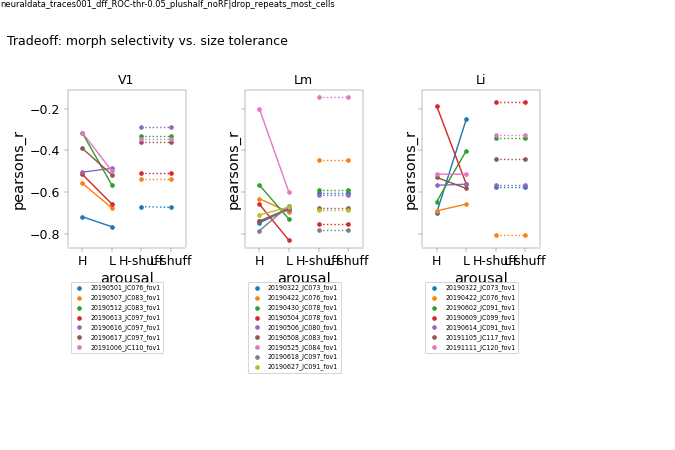

In [192]:

metric='pearsons_r'
#plotd = passcorrs.copy()


fig, axn = pl.subplots(1, 3, figsize=(9,6), sharey=True)

for va, plotd in passcorrs.groupby(['visual_area']):
    
    ai = visual_areas.index(va)
    ax=axn[ai]
    
    curr_hue_order = sorted(plotd['datakey'].unique())
    # True arousal labels
    sns.pointplot(x='arousal', y=metric, hue='datakey', ax=ax,
                  data=plotd[plotd.true_labels==True],
                 hue_order=curr_hue_order, order=['high', 'low', 'high_shuff', 'low_shuff'], 
                 scale=0.5, ci=None)

    # Shuffled arousal labels
    sns.pointplot(x='arousal', y=metric, hue='datakey', ax=ax,
                  data=plotd[plotd.true_labels==False],
                  linestyles=':',hue_order=curr_hue_order, order=['high_shuff', 'low_shuff', 'high', 'low'],
                  scale=0.5, ci=None)

#     sns.pointplot(x='arousal', y=metric, hue='datakey', ax=ax, 
#                   data=plotd[(~plotd.true_labels)],
#                 linestyles='--', hue_order=curr_hue_order, order=['high_shuff', 'low_shuff', 'high', 'low'])
    ax.set_xticklabels(['H', 'L', 'H-shuff', 'L-shuff'])
    nrats = len(curr_hue_order)
    p3.crop_legend_labels(ax, n_hues=nrats, bbox_to_anchor=(0, -0.2), loc='upper left', fontsize=6)
    ax.set_title(va)
    
pl.subplots_adjust(bottom=0.45, top=0.8, left=0.1, right=0.8, wspace=0.5)


fig.text(0.01, 0.9, 'Tradeoff: morph selectivity vs. size tolerance', fontsize=12)
p3.label_figure(fig, '%s|%s' % (data_id, dset_str))

figname = 'tradeoff_pearsons_corrcoef_byFOV__%s' % (dset_str)

pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [193]:
importlib.reload(p3)

<module 'py3utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/py3utils.py'>

In [194]:
df_ = passcorrs[(passcorrs['true_labels']==True)].copy()
statdf = p3.paired_ttests(df_, metric=metric, round_to=3,
                c1='high', c2='low', compare_var='arousal', ttest=False)
statdf

,t_stat,p_val,visual_area
0,1.0,0.031,V1
1,17.0,0.570,Lm
2,11.0,0.688,Li


# Example FOVs

In [37]:
importlib.reload(p3)

<module 'py3utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/notebooks/response_stats/py3utils.py'>

In [38]:
pplot.set_plot_params(lw_axes=0.25, labelsize=6, color='k', dpi=100)


In [39]:
curr_dst_dir = os.path.join(dst_dir, 'example_tuning')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)


/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC/example_tuning


##### Test 1

In [40]:
va='V1'

example_rats = {'V1': '20190616_JC097_fov1',
                'Lm': '20190504_JC078_fov1',
                'Li': '20190422_JC076_fov1'}
#                 'Li': '20190614_JC091_fov1'}
dk = example_rats[va]

rootdir = '/n/coxfs01/2p-data'

session, animalid, fovn = p3.split_datakey_str(dk)
traces, labels = p3.load_corrected_dff_traces(animalid, session, 'FOV%i_zoom2p0x' % fovn, 
                                                return_traces=True, return_labels=True)

stim_on_frame = labels['stim_on_frame'].unique()[0]
nframes_on = labels['nframes_on'].unique()[0]
stim_on_sec = round(stim_on_frame/44.65, 1)


... calculating F0 for df/f


In [41]:
print(va, dk)

V1 20190616_JC097_fov1


In [87]:
offset=True
with_lum = False

sdf = SDF[dk].copy()
if with_lum:
    configs = sdf.index.tolist()
else:
    configs = sdf[sdf['morphlevel']!=-1].index.tolist()
sizes = list(sorted(sdf['size'].unique()))


morphlevels = list(sorted(sdf.loc[configs]['morphlevel'].unique()))
print(morphlevels)

x0 = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk) & (NDATA.config.isin(configs))].copy()

if offset:
    x0['response'] = x0['response'] - x0.groupby(['cell'])['response'].transform('min')
curr_ixs = calculate_indices_for_neuraldf(x0[x0.config.isin(configs)], sdf, 
                                       images_only=images_only)
curr_ixs['visual_area'] = va
curr_ixs['datakey'] = dk

rdf = x0.groupby(['cell', 'config']).mean().reset_index().drop('trial', axis=1)
rdf['size'] = sdf.loc[rdf['config']]['size'].values
rdf['morphlevel'] = sdf.loc[rdf['config']]['morphlevel'].values
rdf.head()

[0, 14, 27, 40, 53, 66, 79, 92, 106]


,cell,config,response,size,morphlevel
0,0,config006,0.208379,10.0,0
1,0,config007,0.197659,20.0,0
2,0,config008,0.219269,30.0,0
3,0,config009,0.227587,40.0,0
4,0,config010,0.264816,50.0,0


In [88]:
#### Generate morph tuning curves
morph_curves = rdf.groupby(['cell']).apply(get_x_curves_at_best_y, 
                x='morphlevel', y='size', normalize=True).reset_index(drop=True)
morph_mat = morph_curves[['cell', 'response', 'morphlevel']].pivot(columns='cell', index='morphlevel')

print(morph_curves['size'].unique())

#### Calculate morph selectivity index
morph_ixs = rdf.groupby(['cell']).apply(assign_morph_ix, at_best_other=True).rename(columns={0:'morph_ix'})
sorted_morph_ixs = morph_ixs.sort_values(by='morph_ix', ascending=False)

#### Generate size tuning curves
size_curves = rdf.groupby(['cell']).apply(get_x_curves_at_best_y, 
                                           x='size', y='morphlevel', normalize=True).reset_index(drop=True)
size_mat = size_curves[['cell', 'response', 'size']].pivot(columns='cell', index='size')

#### Calculate size tolerance
size_tols = rdf.groupby(['cell']).apply(assign_size_tolerance, at_best_other=True).rename(columns={0:'size_tol'})
sorted_size_tols = size_tols.sort_values(by='size_tol', ascending=False)

#### Calculate sparseness
sparse_ixs = rdf[['cell', 'response']].groupby(['cell']).apply(assign_sparseness).rename(columns={0:'sparseness'})

#### Aggregate
best_ixs = pd.concat([size_tols, morph_ixs, sparse_ixs], axis=1).reset_index()
best_ixs.index=best_ixs['cell']
best_ixs.head()

[50. 10. 20. 30. 40.]


,cell,size_tol,morph_ix,sparseness
cell,,,,
0,0,0.805178,0.215545,0.007647
1,1,0.731363,0.068460,0.028965
2,2,0.834057,0.088706,0.005518
9,9,0.902593,0.058931,0.001190
11,11,0.808981,0.089746,0.006658


In [90]:
pplot.set_plot_params(labelsize=6)

<IPython.core.display.Javascript object>


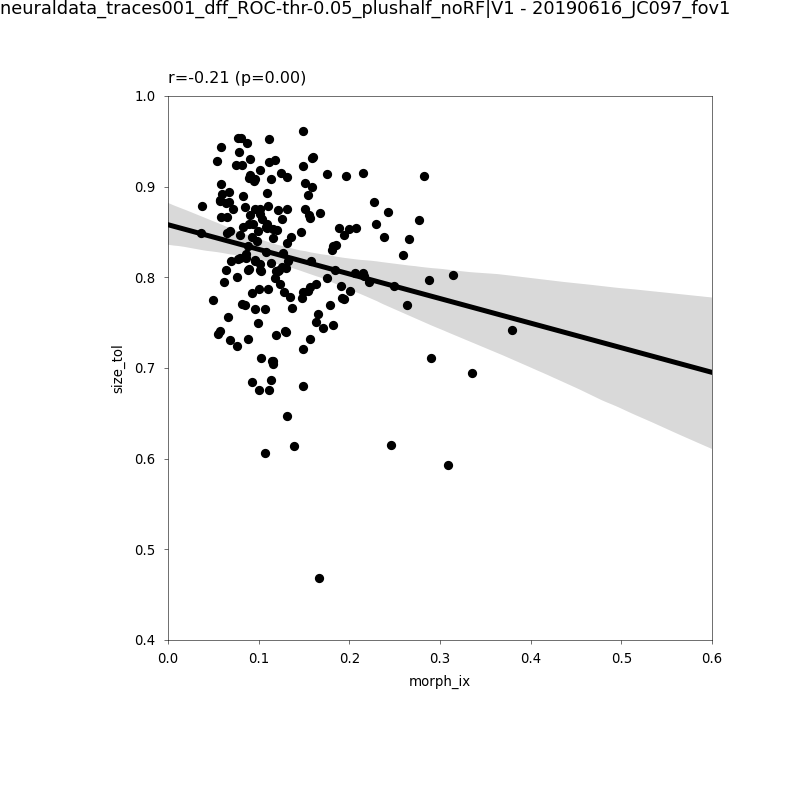

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC/example_tuning tradeoff_V1_20190616_JC097_fov1


In [352]:
fig, ax = pl.subplots(figsize=(5,5))
ax.set_ylim([0.4, 1])
ax.set_xlim([0, 0.6])
ax.tick_params(which='both', axis='both', size=2)
#sns.despine(offset=0)
sns.regplot(x='morph_ix', y='size_tol', data=best_ixs, ax=ax, color='k', truncate=False, 
           scatter_kws={'alpha': 1, 's': 10, 'marker': 'o'})
pearsons_r, pearsons_p = spstats.pearsonr(best_ixs['size_tol'], best_ixs['morph_ix'])
ax.set_title("r=%.2f (p=%.2f)" % (pearsons_r, pearsons_p), loc='left')
pl.subplots_adjust(left=0.2, bottom=0.2)
ax.set_aspect('equal')

p3.label_figure(fig, '%s|%s - %s' % (data_id, va, dk))

figname = 'tradeoff_%s_%s' % (va, dk)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [35]:
va

'Li'

In [91]:
roi_labels = ['high', 'low'] # 'all']
# roi_colors = ['black',  'black'] #, 'k']
# roi_styles = ['-', '--']
roi_colors = ['cornflowerblue',  'orange'] #, 'k']
roi_styles = ['-', '-']


size_labels = [int(s) for s in sorted(sdf['size'].unique())]
morph_labels = [int(s) for s in sorted(sdf['morphlevel'].unique())]
rank_order=False


# V1: 20190616_JC097_fov1
# -----------------------
if va=='V1' and dk=='20190616_JC097_fov1':
    rois_plot_mp = [217, 388] #, 107] #131] #104] #sorted_morph_ixs.iloc[0:topn].index.tolist()
    #rois_plot_sz = [405, 388] #405#[362, 405] #, 107] #107] #sorted_size_tols.iloc[0:topn].index.tolist()
    rois_plot_sz = [217, 388]
    cmaps=['cool', 'cool_r']

elif va=='Lm' and dk=='20190504_JC078_fov1':
    # Li: 20190422_JC076_fov1
    # -----------------------
    rois_plot_mp = [194, 185] #24]
    # rois_plot_sz = [294, 76] 
    rois_plot_sz = [194, 185]
    cmaps=['cool', 'cool_r']
    
elif va=='Li' and dk=='20190422_JC076_fov1':
    # Li: 20190422_JC076_fov1
    # -----------------------
    #rois_plot_mp = [119, 76]
    # rois_plot_sz = [294, 76] 
    #rois_plot_sz = [119, 76] 
    rois_plot_sz = [119, 76] 
    #rois_plot_sz = [293, 76] 
    rois_plot_mp = rois_plot_sz
    cmaps=['cool', 'cool_r']

elif va=='Li' and dk=='20190614_JC091_fov1':
    # Li: 20190422_JC076_fov1
    # -----------------------
    #rois_plot_mp = [119, 76]
    # rois_plot_sz = [294, 76] 
    #rois_plot_sz = [119, 76] 
    rois_plot_sz = [304, 234] #[331, 234] 
    rois_plot_mp = rois_plot_sz
    cmaps=['cool', 'cool_r']
    
    
# Othres.
# # # Li: 20190607_JC091_fov
# rois_plot_mp = [304, 343]
# rois_plot_sz = [304, 343]

# # # Li: 20190607_JC091_fov
# rois_plot_mp = [343, 331] # 331] #, 107] #131] #104] #sorted_morph_ixs.iloc[0:topn].index.tolist()
# rois_plot_sz = [304, 234] #[362, 405] #, 107] #107] #sorted_size_tols.iloc[0:topn].index.tolist()

# # Li: 20191105_JC117_fov1
# rois_plot_mp = [67, 38] # 331] #, 107] #131] #104] #sorted_morph_ixs.iloc[0:topn].index.tolist()
# rois_plot_sz = [78, 19] #[362, 405] #, 107] #107] #sorted_size_tols.iloc[0:topn].index.tolist()

lw=0.25


<IPython.core.display.Javascript object>


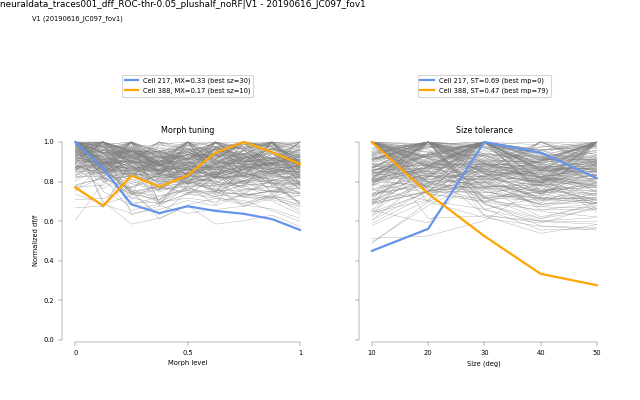

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC/example_tuning tuning_curves_V1_20190616_JC097_fov1


In [94]:
fig, axn = pl.subplots(1,2, figsize=(8,5), sharey=True)

ax=axn[0]

if rank_order:
    xx = morph_mat.copy()
    xx.values.sort(axis=0)
    mm = xx[::-1]
else:
    mm = morph_mat.copy()
    
ax.plot(mm.values, color='gray', alpha=1, lw=lw)
ax.set_title("Morph tuning")
for ls, col, rid in zip(roi_styles, roi_colors, rois_plot_mp):
    best_sz = int(morph_curves[morph_curves['cell']==rid]['size'].unique())
    ax.plot(mm['response', rid].values, color=col, lw=2, linestyle=ls,
                label='Cell %i, MX=%.2f (best sz=%i)' 
            % (rid, best_ixs.loc[rid]['morph_ix'], best_sz))
    
xlabel = 'Rank-ordered morphs' if rank_order else 'Morph level' 
xtick_ixs = np.linspace(0, len(morph_labels)-2, 3, endpoint=True)
ax.set_xticks(xtick_ixs)
xticks = xtick_ixs+1 if rank_order else [0, 0.5, 1]
ax.set_xticklabels(xticks)
ax.set_xlabel(xlabel, fontsize=fontsize)
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='lower center', fontsize=fontsize)
ax.set_ylim([0, 1])

# --------------------------------------------------------------
# Size Tolerance
# --------------------------------------------------------------
ax=axn[1]
rank_order=False
if rank_order:
    xx = size_mat.copy()
    xx.values.sort(axis=0)
    sz = xx[::-1]
else:
    sz = size_mat.copy()
    
ax.plot(sz.values, color='gray', alpha=1, lw=lw)
ax.set_title("Size tolerance")

for ls, col, rid in zip(roi_styles, roi_colors, rois_plot_sz):
    best_mp = int(size_curves[size_curves['cell']==rid]['morphlevel'].unique())
    ax.plot(sz['response', rid].values, color=col, lw=2, linestyle=ls,
                label='Cell %i, ST=%.2f (best mp=%i)'
            % (rid, best_ixs.loc[rid]['size_tol'], best_mp))
xlabel = 'Rank-ordered size pref.' if rank_order else 'Size (deg)'
xticks = np.arange(0, len(size_labels)) # if rank_order else size_labels
ax.set_xticks(xticks)
ax.set_xticklabels(size_labels)

ax.set_xlabel(xlabel, fontsize=fontsize)
ax.set_ylim([0, 1.01])
ax.legend(bbox_to_anchor=(0.5, 1.2), loc='lower center', fontsize=fontsize)

sns.despine(offset=2, trim=True)
axn[0].set_ylabel('Normalized df/f')
fig.text(0.05, 0.95, '%s (%s)' % (va, dk), fontsize=fontsize)

p3.label_figure(fig, '%s|%s - %s' % (data_id, va, dk))

pl.subplots_adjust(wspace=0.2, left=0.1, right=0.95, top=0.65, bottom=0.15)

figname = 'tuning_curves_%s_%s' % (va, dk)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

In [57]:
fontsize=6


In [361]:
va, dk

('V1', '20190616_JC097_fov1')

In [88]:


def smooth_timecourse(in_trace, win_size=41):
    #smooth trace
    win_half = int(round(win_size/2))
    trace_pad = np.pad(in_trace, ((win_half, win_half)), 'reflect') # 'symmetric') #'edge')

    smooth_trace = np.convolve(trace_pad, np.ones((win_size,))*(1/float(win_size)),'valid')
    
    return smooth_trace

def smooth_traces_trial(gg, win_size=5, colname='trial'):
    smoothed_ = smooth_timecourse(gg, win_size=win_size)
    return pd.Series(smoothed_)

In [60]:
use_plain_colors=True
# [V1] 20190616_JC097_fov1 
# -------------------------------------------
# Tolerant:  217, 388
# 388 (best=10): mid=30, worst=50 | "cool_r"
# 217 (best=30): mid=20, worst=10 | "cool"
if va=='V1' and dk=='20190616_JC097_fov1':
    if use_plain_colors:
        roi_cmap= {217: 'k', 388: 'k'}
    else:
        roi_cmap= {217: 'cool', 388: 'cool_r'}
    ranked_sizes = {388: {'mid': 30, 'worst': 50},
                    217: {'mid': 20, 'worst': 10}}

elif va=='Lm' and dk=='20190504_JC078_fov1':
    # [Lm] 20190504_JC078_fov1 
    # ------------------------------------------- _
    # 194 (best=50): mid=40, worst=30 | "cool"
    # 185 (best=50): mid=40, worst=30 | "cool_r"
    if use_plain_colors:
        roi_cmap= {194: 'k', 185: 'k'}
    else:
        roi_cmap= {194: 'cool', 185: 'cool_r'}
    ranked_sizes = {194: {'mid': 40, 'worst': 30},
                    185: {'mid': 40, 'worst': 30}}
    
elif va=='Li':
    if dk=='20190422_JC076_fov1':
        # [Li] 20190422_JC076_fov1 
        # -------------------------------------------
        # Tolerant:  119, _
        # 119 (best=10): mid=30, worst=50 | "cool"
        # 76 (best=10): mid=30, worst=40 | "cool_r"
        if use_plain_colors:
            roi_cmap = {119: 'k', 76: 'k'}
            #roi_cmap = {293: 'k', 76: 'k'}
        else:
            roi_cmap= {119: 'cool', 76: 'cool_r'}
            #roi_cmap= {293: 'cool', 76: 'cool_r'}
            
        ranked_sizes = {293: {'mid': 30, 'worst': 10},
                        119: {'mid': 30, 'worst': 50},
                        76: {'mid': 30, 'worst': 40}}
    elif dk=='20190614_JC091_fov1':
        # [Li] 20190614_JC091_fov1 #JC076_fov1 
        # -------------------------------------------
        if use_plain_colors:
            roi_cmap = {304: 'k', 234: 'k'}
        else:
            roi_cmap= {304: 'cool', 234: 'cool_r'}
        ranked_sizes = {331: {'mid': 40, 'worst': 30},
                        304: {'mid': 20, 'worst': 10},
                        234: {'mid': 30, 'worst': 50}}



# [Li] 20190422_JC076_fov1, 293 (best=50): mid=30, worst=10 | "Greens"

# [Li] 20190614_JC091_fov1
# -------------------------------------------
# Tolerant:  304, 234, 331, 343
# 304 (best=50, mid=20, worst=10) | "Greens"
# 234 (best=30, mid=30, worst=50) | "Purples"
# 343 (best=50, mid=40, worst=10) | "Purples"

In [83]:
rois_ = rois_plot_sz #list(roi_cmap.keys())

curr_roi_ix = 0
curr_roi_col = roi_colors[curr_roi_ix]

rid = rois_[curr_roi_ix] # 194
curr_cmap= roi_cmap[rid] #'cool_r'
mid_v = ranked_sizes[rid]['mid']
worst_v = ranked_sizes[rid]['worst']
# ==============================================================================

x='morphlevel'; y='size';
fbest = int(morph_curves[morph_curves['cell']==rid][y].unique())
print(fbest)
curves_mid = rdf.groupby(['cell']).apply(get_x_curves_at_given_size,
                    x='morphlevel', y='size', val_y=mid_v, normalize=True).reset_index(drop=True)

curves_worst = rdf.groupby(['cell']).apply(get_x_curves_at_given_size,
                    x='morphlevel', y='size', val_y=worst_v, normalize=True).reset_index(drop=True)

fmid = int(curves_mid[curves_mid['cell']==rid][y].unique())
fworst = int(curves_worst[curves_worst['cell']==rid][y].unique())
ranked_hues = [fbest, fmid, fworst]
print(ranked_hues)


fill_sem=False
index_to_plot='morph_ix'
if use_plain_colors:
    colors=[curr_cmap]*3
else:
    colors=sns.color_palette(curr_cmap, n_colors=3*2) #[0::2]
hue_ = 'morphlevel' if index_to_plot=='size_tol' else 'size'
subplot_par = 'size' if hue_=='morphlevel' else 'morphlevel'


30
[30, 20, 10]


# PLOT PLAIN

In [84]:
with_lum = True
lum_str = '_wLUM' if with_lum else ''

sdf = SDF[dk].copy()
if with_lum:
    curr_cfgs = sdf.index.tolist()
else:
    curr_cfgs = sdf[sdf['morphlevel']!=-1].index.tolist()
sizes = list(sorted(sdf['size'].unique()))

best_cfgs = sdf[(sdf[hue_]==fbest) & (sdf.morphlevel!=-1)].index.tolist()

rtraces = labels.copy()
rtraces['dff'] = traces[rid].copy()
currt = rtraces[rtraces.config.isin(curr_cfgs)].copy()

currt['size'] = sdf.loc[currt['config']]['size'].values
currt['morphlevel'] = sdf.loc[currt['config']]['morphlevel'].values


In [85]:
morphlevels
M = morphlevels[1:]
M.append(morphlevels[0])
print(M)

[0, 14, 27, 40, 53, 66, 79, 92, 106, -1]


<IPython.core.display.Javascript object>


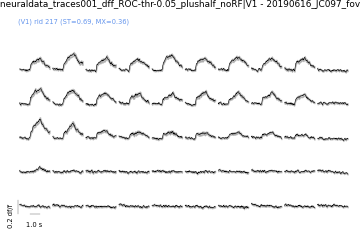

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC/example_tuning


In [86]:
fill_sem=True
mean_only=False

fig, axn = pl.subplots(5, len(morphlevels), figsize=(4.5, 3), sharex=True, sharey=True)
for (sz, mp), g in currt.groupby(['size', 'morphlevel']):
    si = sizes[::-1].index(sz)
    mi = M.index(mp)
    ax=axn[si, mi]
    ax.patch.set(alpha=0)

    t_df = g.groupby(['trial'])['dff'].apply(smooth_traces_trial, win_size=5).unstack().T
    mean_t = np.nanmean(t_df, axis=1)
    std_t = np.nanstd(t_df, axis=1)
    sem_t = spstats.sem(t_df, axis=1, nan_policy='omit')

    if not mean_only:
        if fill_sem:
            #ax.fill_between(np.arange(0, len(mean_t)), mean_t-std_t, mean_t+std_t, alpha=0.2, color='k')
            ax.fill_between(np.arange(0, len(mean_t)), mean_t-sem_t, mean_t+sem_t, alpha=0.2, color='k')
        else:
            ax.plot(t_df, lw=0.1, color='gray', alpha=1) #'k')
    ax.plot(mean_t, lw=.5, c='k', linestyle=ls) #, label='%s %i' % (hue_, curr_hue))

    # format
    if not (mi==0 and si==len(sizes)-1):
        ax.axis('off')
    else:
        sns.despine(trim=True, ax=ax) #, bottom=True, left=True, ax=ax)

        
    ax.set_xticks([stim_on_frame, stim_on_frame+nframes_on])
    ax.tick_params(which='both', axis='both', size=0)
    ax.set_xticklabels([])
    ax.set_yticks([0.0, 0.1, 0.2])
    ax.set_yticklabels(['', '0.2 df/f', ''], rotation=90)
    ax.set_xlabel('%s s' % (stim_on_sec))
    ax.set_ylim([0.0, 0.7])
#sns.despine(trim=True, offset=0.2)
pl.subplots_adjust(left=0.05, right=0.97, wspace=0, hspace=-.3)

fig.text(0.05, 0.9, '(%s) rid %i (ST=%.2f, MX=%.2f)' \
             % (va, rid, best_ixs.loc[rid]['size_tol'], best_ixs.loc[rid]['morph_ix']), color=curr_roi_col)
    
p3.label_figure(fig, '%s|%s - %s' % (data_id, va, dk))

pl.savefig(os.path.join(curr_dst_dir, 'traces%s_%s_%s_cell%03d.svg' % (lum_str, va, dk, rid)))
print(curr_dst_dir)

In [300]:
round(stim_on_frame/44.65, 1)


1.0

In [95]:
def my_palplot(pal, size=1, ax=None, xticks=None):
    """Plot the values in a color palette as a horizontal array.
    Parameters
    ----------
    pal : sequence of matplotlib colors
        colors, i.e. as returned by seaborn.color_palette()
    size :
        scaling factor for size of plot
    ax :
        an existing axes to use
    """

    import numpy as np
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    
    n = len(pal)
    if xticks is None:
        xticks = ["" for _ in range(n)]
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    # Ensure nice border between colors
    ax.set_xticklabels(xticks)
    # The proper way to set no ticks
    ax.yaxis.set_major_locator(ticker.NullLocator())

<IPython.core.display.Javascript object>


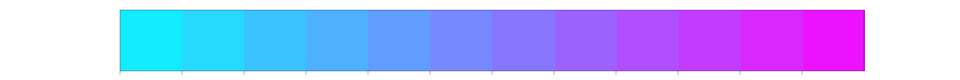

In [96]:
fig, ax = pl.subplots(figsize=(12, 1))

col1 = sns.color_palette('cool', n_colors=12)
my_palplot(col1, ax=ax)

pl.savefig(os.path.join(curr_dst_dir, 'color_legends.svg'))

<IPython.core.display.Javascript object>


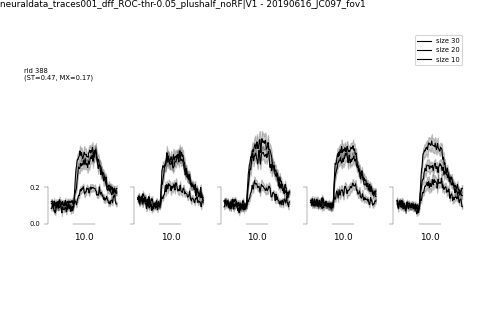

In [98]:
## stplit out PSTH

fill_sem=True
subplot_par='size'

nplots = len(sdf[subplot_par].unique())-1 if subplot_par=='morphlevel' \
            else  len(sdf[subplot_par].unique())
fig, axn = pl.subplots(1, nplots, figsize=(nplots*1.2, 4), sharex=True, sharey=True)
lw=1
for col, curr_hue in zip(colors, ranked_hues):
    curr_cfgs = sdf[(sdf[hue_]==curr_hue) & (sdf.morphlevel!=-1)].index.tolist()
    rtraces = labels.copy()
    rtraces['dff'] = traces[rid].copy()
    currt = rtraces[rtraces.config.isin(curr_cfgs)]
    
    m_=[]; s_=[];
    for ax, (k, gg) in zip(axn.flat, currt.groupby(['config'])):
        t_df = gg.groupby(['trial'])['dff'].apply(smooth_traces_trial, win_size=2).unstack().T
        t = np.nanmean(t_df, axis=1)
        s = spstats.sem(t_df, axis=1, nan_policy='omit')
        if fill_sem:
            ax.fill_between(np.arange(0, len(t)), t-s, t+s, alpha=0.2, color=col)
        else:
            ax.plot(t_df, lw=0.2, color='gray', alpha=0.5) #'k')
        ax.plot(t, lw=lw, c=col, linestyle=ls, label='%s %i' % (hue_, curr_hue))
        
        # format
        ax.set_xticks([stim_on_frame, stim_on_frame+nframes_on])
        ax.tick_params(which='both', axis='x', size=0)
        ax.set_xlabel(sdf[subplot_par][k], fontsize=8)
        ax.set_xticklabels([])
        ax.set_yticks([0.0, 0.2])
        ax.set_ylim([0.0, 0.7])
    sns.despine(trim=True, offset=0.2)
    
    
fig.text(0.05, 0.75, 'rid %i\n(ST=%.2f, MX=%.2f)' \
             % (rid, best_ixs.loc[rid]['size_tol'], best_ixs.loc[rid]['morph_ix']))
    
p3.label_figure(fig, '%s|%s - %s' % (data_id, va, dk))
pl.subplots_adjust(bottom=0.3, left=0.1, right=0.97, top=0.7)
ax.legend(bbox_to_anchor=(1, 1.5), loc='upper right', fontsize=6)

#pl.savefig(os.path.join(curr_dst_dir, '%s_%s_cell%03d.svg' % (va, dk, rid)))

<IPython.core.display.Javascript object>


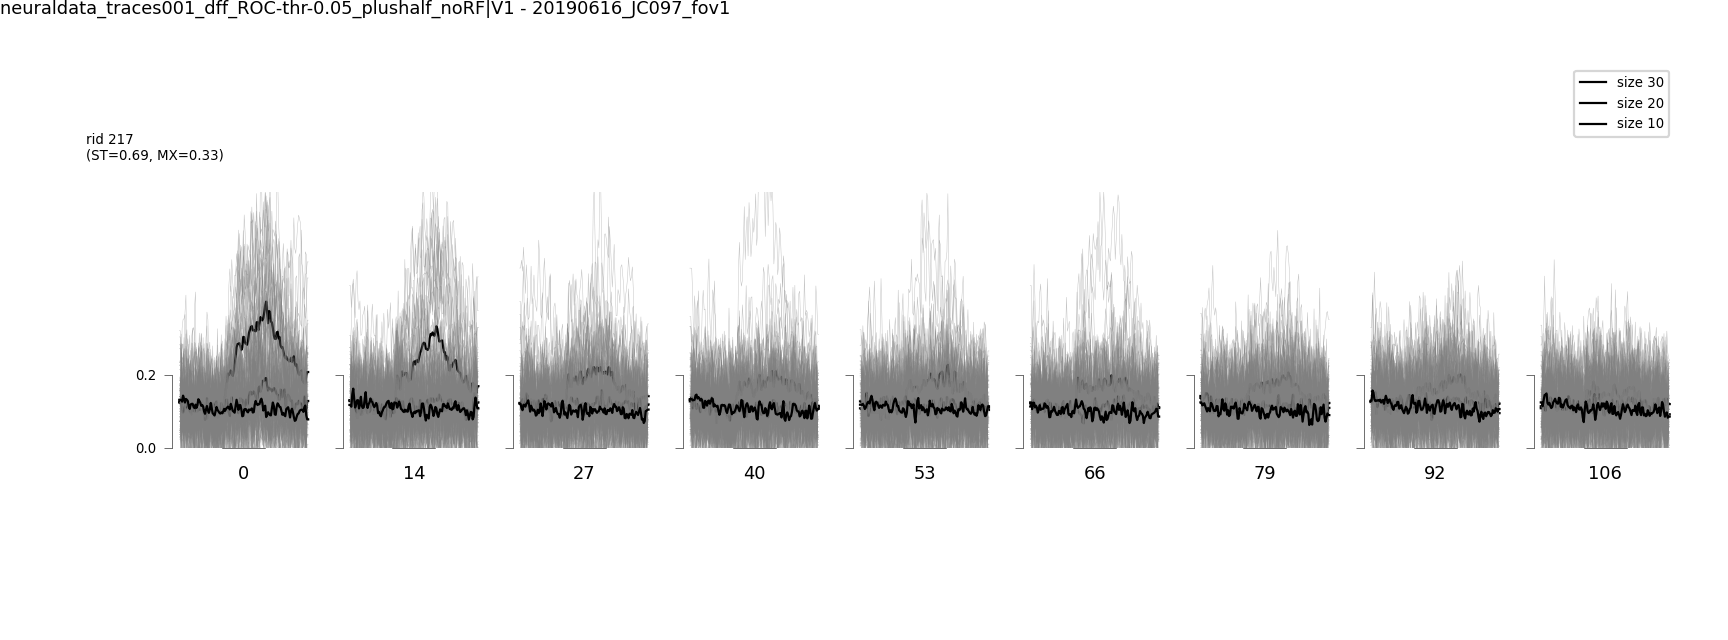

In [134]:
fill_sem=True

nplots = len(sdf[subplot_par].unique())-1 if subplot_par=='morphlevel' else  len(sdf[subplot_par].unique())
fig, axn = pl.subplots(1, nplots, figsize=(nplots*1.2, 4), sharex=True, sharey=True)
lw=1
for col, curr_hue in zip(colors, ranked_hues):
    curr_cfgs = sdf[(sdf[hue_]==curr_hue) & (sdf.morphlevel!=-1)].index.tolist()
    rtraces = labels.copy()
    rtraces['dff'] = traces[rid].copy()
    currt = rtraces[rtraces.config.isin(curr_cfgs)]
    
    m_=[]; s_=[];
    for ax, (k, gg) in zip(axn.flat, currt.groupby(['config'])):
        t_df = gg.groupby(['trial'])['dff'].apply(smooth_traces_trial, win_size=2).unstack().T
        t = np.nanmean(t_df, axis=1)
        s = spstats.sem(t_df, axis=1, nan_policy='omit')
        if fill_sem:
            ax.fill_between(np.arange(0, len(t)), t-s, t+s, alpha=0.2, color=col)
        else:
            ax.plot(t_df, lw=0.2, color='gray', alpha=0.5) #'k')
        ax.plot(t, lw=lw, c=col, linestyle=ls, label='%s %i' % (hue_, curr_hue))
        
        # format
        ax.set_xticks([stim_on_frame, stim_on_frame+nframes_on])
        ax.tick_params(which='both', axis='x', size=0)
        ax.set_xlabel(sdf[subplot_par][k], fontsize=8)
        ax.set_xticklabels([])
        ax.set_yticks([0.0, 0.2])
        ax.set_ylim([0.0, 0.7])
    sns.despine(trim=True, offset=0.2)
    
    
fig.text(0.05, 0.75, 'rid %i\n(ST=%.2f, MX=%.2f)' \
             % (rid, best_ixs.loc[rid]['size_tol'], best_ixs.loc[rid]['morph_ix']))
    
p3.label_figure(fig, '%s|%s - %s' % (data_id, va, dk))
pl.subplots_adjust(bottom=0.3, left=0.1, right=0.97, top=0.7)
ax.legend(bbox_to_anchor=(1, 1.5), loc='upper right', fontsize=6)

#pl.savefig(os.path.join(curr_dst_dir, '%s_%s_cell%03d.svg' % (va, dk, rid)))

In [619]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC/example_tuning'

In [881]:
in_trials=None; in_neural=None;
session, animalid, fovnum = p3.split_datakey_str(dk)
sdf = SDF[dk].copy()
configs = sdf.index.tolist()

# Load split_pupil input
curr_id = p3.decode_analysis_id(visual_area=va, prefix='split_pupil', response_type=response_type, 
                    responsive_test=responsive_test, overlap_thr=overlap_thr, trial_epoch=trial_epoch)
res = p3.load_split_pupil_input(animalid, session, fovnum, curr_id=curr_id, traceid=traceid)



# Group by iteration
in_trials = res['input_trials'].copy()
in_neural = res['neuraldf'].copy()
curr_rois = [r for r in in_neural.columns if p3.isnumber(r)]
ndf = nd[(nd['cell'].isin(curr_rois))].copy()
ndf['response'] = ndf['response'] - ndf.groupby(['cell'])['response'].transform('min')


In [883]:
session, animalid, fovn = aggr.split_datakey_str(datakey)
traces, labels = aggr.load_corrected_dff_traces(animalid, session, 'FOV%i_zoom2p0x' % fovn, 
                                                return_traces=True, return_labels=True)


stim_on_frame = labels['stim_on_frame'].unique()[0]
nframes_on = labels['nframes_on'].unique()[0]

In [886]:

def split_high_low(in_trials, in_neural, sdf):
    curr_configs=sdf[sdf['morphlevel']!=-1].index.tolist()

    # LOW trials
    ctrials_lo = in_trials[(in_trials.arousal=='low') & (in_trials['true_labels']==True)].copy()
    curr_rois = [r for r in in_neural.columns if p3.isnumber(r)]
    currdf_lo = in_neural.loc[ctrials_lo['trial'].values].copy().drop_duplicates()

    df_lo = currdf_lo[currdf_lo.config.isin(curr_configs)].groupby(['config']).mean().reset_index()
    X_lo = df_lo[curr_rois].reset_index(drop=True)
    y_lo = df_lo['config'].reset_index(drop=True)

    
    # HIGH trials
    ctrials_hi = in_trials[(in_trials.arousal=='high') & (in_trials['true_labels']==True)].copy()
    curr_rois = [r for r in in_neural.columns if p3.isnumber(r)]
    currdf_hi = in_neural.loc[ctrials_hi['trial'].values].copy().drop_duplicates()

    df_hi = currdf_hi[currdf_hi.config.isin(curr_configs)].groupby(['config']).mean().reset_index()
    X_hi = df_hi[curr_rois].reset_index(drop=True)
    y_hi = df_hi['config'].reset_index(drop=True)
    return X_lo, y_lo, X_hi, y_hi

In [899]:
# curr_dst_dir = os.path.join(dst_dir, 'split_pupil', 'pca')
# if not os.path.exists(curr_dst_dir):
#     os.makedirs(curr_dst_dir)
# print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/selectivity_tolerance/ROC/split_pupil/pca


In [888]:

# X_lo, y_lo, X_hi, y_hi = split_high_low(in_trials, in_neural, sdf)
# X_lo.shape, X_hi.shape
# RANDOM_STATE = 42
